<a href="https://colab.research.google.com/github/SergeyHSE/LinearRegressor.github.io/blob/main/RegressionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task
1. Analysis of descriptive statistics
2. Estimating a regression model under the assumptions of a classical linear regression model (CLRM)
3. Estimation of regression model under deviations from CERM assumptions:
 - Diagnosis of single atypical observations
 - Diagnosis of sample homogeneity
 - Diagnostics of specification errors and model correction when they are detected
 - Diagnosis of multicollinearity and model correction when it is detected
 - Diagnosis of heteroscedasticity and model correction when it is detected
 - Diagnosis of endogeneity and model correction when it is detected

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
import warnings
warnings.filterwarnings("ignore")

## Introduction
When studying the literature on this topic, the most interesting articles were "Economic efficiency of beef cattle production in Thailand" by Professor Suneeporn Suwanmaneepong of King Mongkut's Institute of Technology Ladkrabang Faculty of Agricultural Technology PhD and "Assessment of technical efficiency and its determinants in beef cattle production in Kenya" by Eric Ruto of Lincoln University. In this paper, the professor describes the economic efficiency of livestock production. To build the model she uses the following variables as the most efficient ones: cost of feed and additives, equipment, drugs and labor, access to priority markets, etc. Unfortunately, our data do not contain information on the costs of purchasing veterinary drugs, so we will not be able to analyze their impact on the profitability of the enterprise. Therefore, we will do something else: we will deduct from the cost price all the cost items that we have. This will give us the amount including the costs of veterinary drugs.

Moreover, both authors conclude in the conclusions of their studies that there is a need for government intervention with different types of assistance such as:
- Improving farmers' access to the knowledge they need to develop their farms as well as their farming skills
- Providing access to more modern technologies
- Improving access to market services
- Creating opportunities for off-farm income generation.

All these factors are in one way or another related to government support, to a certain type of subsidy, which directly, according to the authors, should improve profit margins, and therefore improve the model's performance.


In [8]:
from google.colab import files

uploaded = files.upload()

Saving agro_census.dta to agro_census.dta


In [9]:
data = pd.read_stata('/content/agro_census.dta')
data.columns, data.shape

(Index(['NPPP', 'COD_COATO', 'KFS', 'KOPF', 'OKVED', 'land_total',
        'cost_milk_KRS', 'cost_KRS_food', 'cost_meat_KRS', 'AB_1', 'CF_1',
        'short_credit', 'long_credit', 'debit_debt', 'credit_debt',
        'gov_sup_plant', 'gov_sup_seed', 'gov_sup_grain', 'subs_plant',
        'subs_grain', 'gov_sup_farming', 'gov_sup_KRS', 'subs_prod_farm',
        'subs_milk', 'subs_meat', 'subs_KRS', 'subs_combikorm', 'sub_chemistry',
        'subs_fuel', 'farms_number', 'profit_farms_number',
        'unprofit_farms_number', 'capital', 'profit', 'unprofit', 'J', 'O',
        'empl_org', 'empl_prod', 'V', 'W', 'X', 'AN', 'AO', 'AP', 'AQ', 'AR',
        'BE', 'BF', 'BG', 'BQ', 'BR', 'BS', 'BT', 'BU', 'BY', 'BZ', 'CA',
        'salary_plant', 'salary_farm', 'DB', 'DC', 'DF', 'DG', 'DH', 'DI', 'DK',
        'DO', 'DT', 'EC', 'EG', 'EJ', 'EK', 'ER', 'ES', '_merge'],
       dtype='object'),
 (6287, 76))

In [10]:
df = data[(data['OKVED'] == '01.21')]
df = df.reset_index(drop=True)
df.shape

(2595, 76)

In [11]:
df['net_profit'] = df['profit'] - df['unprofit']
df['other_cost'] = df['DG'] - df['salary_farm'] - df['DC'] - df['DI']
df['subsidies'] = df['gov_sup_KRS'] + df['subs_prod_farm'] + df['subs_milk'] + df['subs_KRS'] + df['subs_combikorm'] + df['subs_fuel']
df['debt'] = df['credit_debt'] - df['debit_debt']
df['cost_services'] = df['J'] - df['O']

In [12]:
df.rename(columns={'DC' : 'amortization',
                   'DI' : 'social_cost'}, inplace=True)
df['output'] = df['AP'] + df['BE'] + df['BS']

In [13]:
column_names = ['net_profit', 'other_cost', 'subsidies', 'debt',
                'cost_services', 'amortization', 'output', 'salary_farm',
                'empl_org', 'KOPF', 'social_cost', 'long_credit']
livestock = df[column_names]
livestock.shape

(2595, 12)

We ended up with the following variables:
 - net_profit (thousand rub) - net profit of livestock production.
 - other_cost (thousand rub) - costs, which include, among other things, costs for repayment of loans and for purchase of veterinary drugs, cost for fuil, electricity and so on.
 - social_cost (thousand rub) - deductions for social needs.
 - subsidies (thousand rub) - total amount of subsidies, including subsidies for milk and meat production, fuel subsidies, etc.
 - debt (thousand rub) - current short-term debts (difference between accounts payable and accounts receivable).
 - cost_services (thousand rub) - cost_services - cost of sold goods, products, works, services (industrial products, goods, works and services).
 - amortization (thousand rub) - amortization.
 - output (centner) - gross output of milk, meat, cattle.
 - salary_farm (thousand rub) - labor costs.
 - empl_org (number of employees) - Average annual number of employees of the agricultural organization.
 - KOPF - (42
Unitary enterprises, based on the right of economic management;
47
Open joint stock companies;
52
Production cooperatives;
65
Limited liability companies;
67
Closed joint-stock companies;
54
Collective farms;
55
State farms.)

In [14]:
livestock.head()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,KOPF,social_cost,long_credit
0,8931.0,41323.0,3892.0,26477.0,13232.0,2114.0,2693.0,8735.0,294,47,1147,6547.0
1,2495.0,19419.0,3710.0,11271.0,1719.0,582.0,1678.0,3827.0,166,52,490,5672.0
2,98.0,24399.0,4096.0,18952.0,5407.0,572.0,3043.0,6790.0,235,67,1014,8200.0
3,-4868.0,5718.0,207.0,10718.0,1254.0,162.0,668.0,1432.0,95,52,182,7061.0
4,-3457.0,12246.0,825.0,3060.0,8019.0,0.0,332.0,1645.0,136,67,210,0.0


In [15]:
# Calculate NaN
livestock.isnull().sum()

net_profit       0
other_cost       0
subsidies        0
debt             0
cost_services    0
amortization     0
output           0
salary_farm      0
empl_org         0
KOPF             0
social_cost      0
long_credit      0
dtype: int64

In [16]:
# Calculate zeros
(livestock == 0).sum()

net_profit         25
other_cost         77
subsidies         249
debt               25
cost_services     275
amortization      154
output            101
salary_farm        82
empl_org            0
KOPF                0
social_cost        90
long_credit      1250
dtype: int64

In [17]:
livestock = livestock.loc[~(livestock == 0).all(axis=1)]
livestock.shape

(2595, 12)

In [18]:
(livestock < 0).sum()

net_profit       469
other_cost         0
subsidies          0
debt             380
cost_services      0
amortization       0
output             0
salary_farm        0
empl_org           0
KOPF               0
social_cost        0
long_credit        0
dtype: int64

In [19]:
livestock.describe()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,KOPF,social_cost,long_credit
count,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000
mean,7841.578343,25980.056262,4313.216817,14084.024663,4259.199615,1647.998073,2848.882312,7750.120617,152.261657,55.442389,1179.604239,5619.182659
std,26857.090812,35396.334481,8416.003095,49316.495885,13197.489220,2661.216427,7633.231854,9493.783825,129.003540,8.535656,1579.778162,18569.989937
min,-117594.000000,0.000000,0.000000,-642913.000000,0.000000,0.000000,0.000000,0.000000,1.000000,42.000000,0.000000,0.000000
25%,134.500000,7952.500000,510.500000,916.000000,290.000000,224.000000,629.000000,2532.000000,81.000000,52.000000,323.000000,0.000000
50%,2889.000000,16692.000000,1669.000000,5085.000000,1123.000000,742.000000,1292.000000,5323.000000,125.000000,52.000000,710.000000,127.000000
75%,9903.000000,31897.000000,4685.000000,15042.000000,3432.000000,1900.000000,2368.000000,9783.000000,189.500000,65.000000,1476.000000,4295.000000
max,732684.000000,907368.000000,163506.000000,842063.000000,330164.000000,32719.000000,120690.000000,225988.000000,2251.000000,67.000000,27666.000000,388300.000000




Thus we got the average company based on 2595 observations that the average net profit is 7842 thousand rubles with a high standard deviation of 26857 thousand rubles, while the most unprofitable company is the company with a net profit of -117594 thousand rubles, and the most profitable company has a profit of 732684 thousand rubles. The difference between the richest companies and 75% of other companies is also visible.

We can see that enterprises are heavily indebted. This is reflected in two variables: the difference between accounts payable and accounts receivable (debt) and costs, which include the costs of loan repayment (other_cost). At the same time, there are companies in which accounts receivable significantly prevail over accounts payable (this is evident from the negative value of -642913 thousand rubles).

In general, if we look at all variables, we can see that the sample is very heterogeneous. This is evidenced by high standard deviations and the difference between the values of 75% of all enterprises and the maximum values.



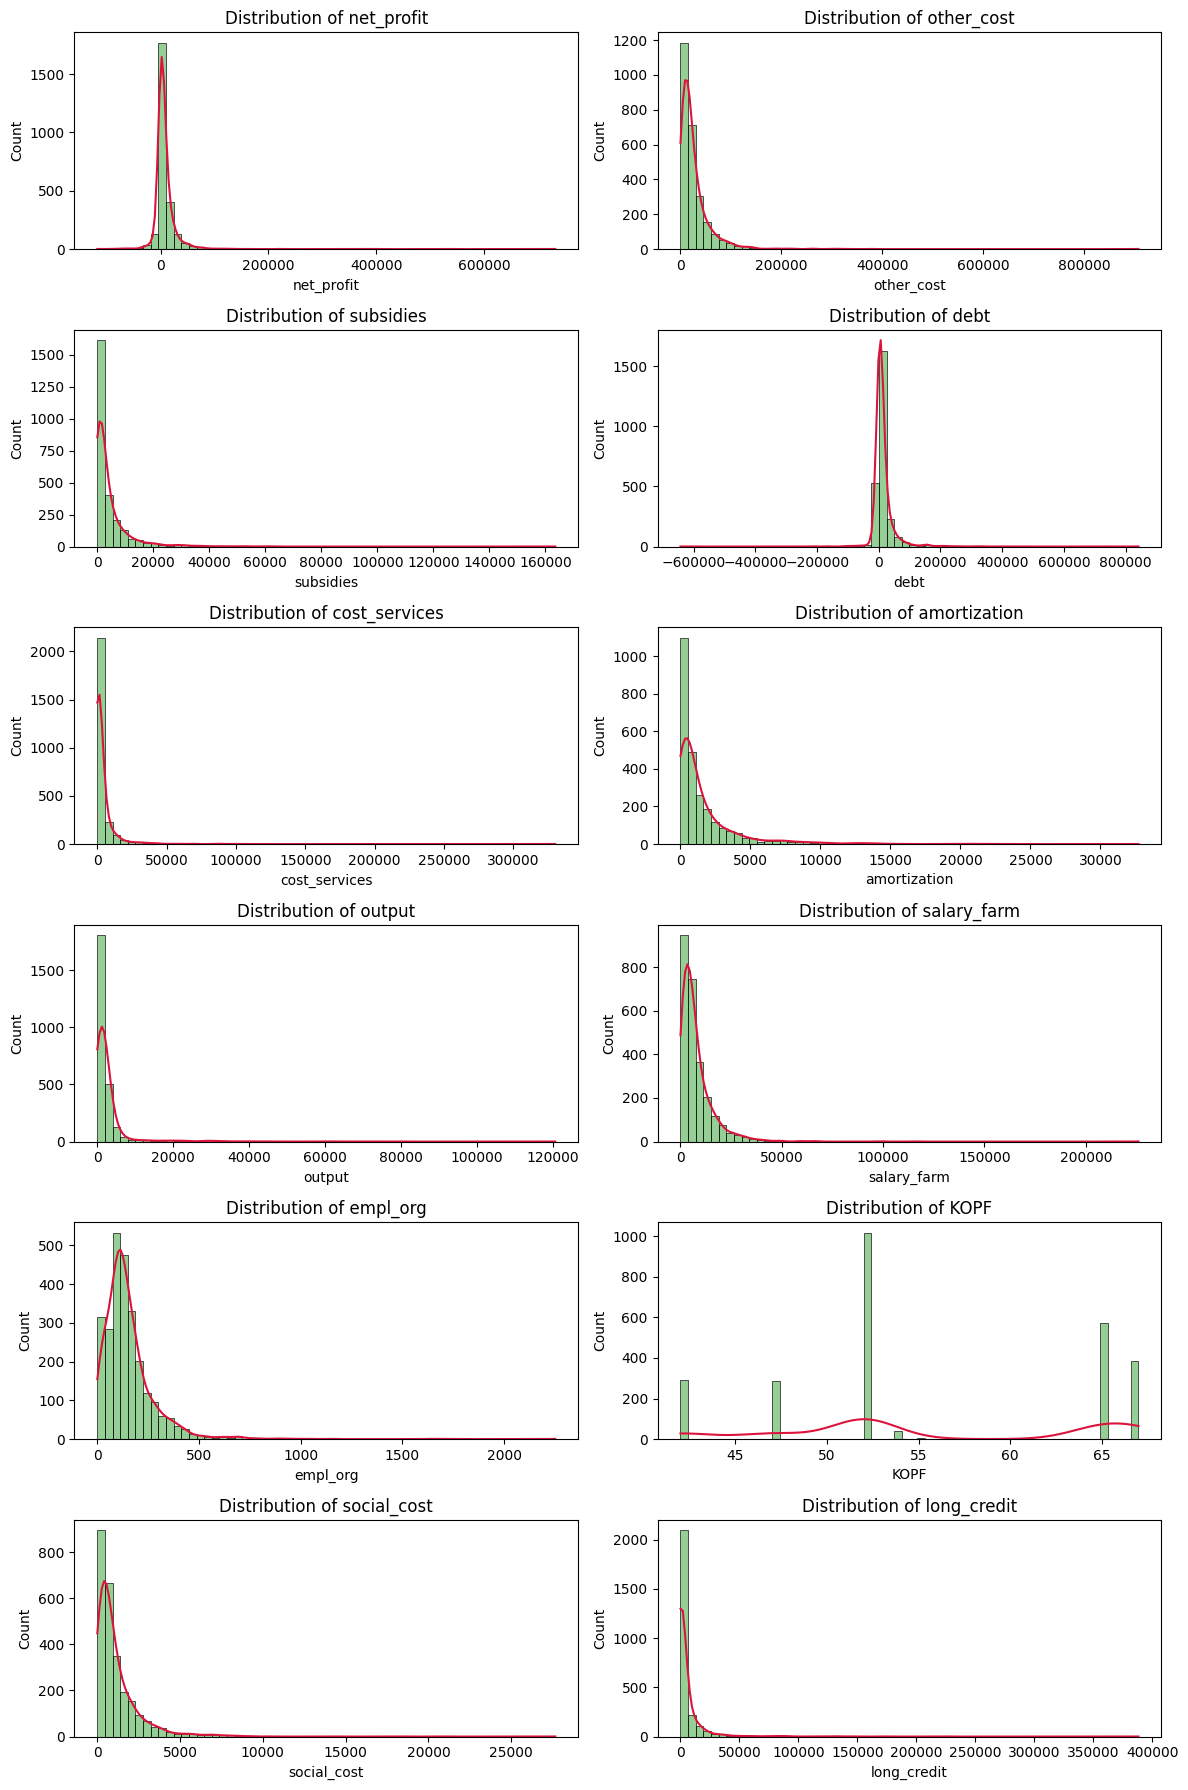

In [20]:
feature_names = list(livestock.columns)
num_rows = 6
num_cols = 2
num_plots = len(feature_names)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 18), dpi=100)
axes = axes.flatten()

for i in range(num_plots):
    if i < num_plots:
        ax = axes[i]
        feature_data = livestock[feature_names[i]]
        b = sns.histplot(data=feature_data, bins=60, kde=True, color='tab:green', ax=ax)
        b.lines[0].set_color('crimson')
        ax.set_title(f'Distribution of {feature_names[i]}')

plt.tight_layout()
plt.show()


The above graphs show that the distribution of each observation is uneven and very different from the normal distribution. This was also evident from the descriptive statistics. Many observations are concentrated near low values, which indicates a large number of small enterprises in this industry and a very small number of large enterprises. At the same time, it can be seen that profits are concentrated in a small number of enterprises, i.e. large companies own most of the profits, creating more products.

Summing up the entire sample we can determine that the average enterprise receives subsidies in the amount of 4313 thousand rubles has costs in the form of debt burden (14084 thousand rubles), in the form of labor costs (7750 thousand rubles), in the form of social costs (1179 thousand rubles), in the form of depreciation (2849 thousand rubles), in the form of costs for work-services (4259 thousand rubles) and in the form of other costs (5980 thousand rubles) at the output of 2848 centners and the number of employees of 152 people.

In [21]:
# Create dummy
# agricultural organizations (KOPF= 47 52 54 55 65 67)
# peasant (farmer) farms and individual entrepreneurs (KOPF= 42).

livestock['dumm'] = 0
livestock.loc[livestock['KOPF'] == 42, 'dumm'] = 1
livestock = livestock.drop('KOPF', axis=1)
livestock = livestock.rename(columns={'dumm' : 'KOPF'})
livestock.head()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,social_cost,long_credit,KOPF
0,8931.0,41323.0,3892.0,26477.0,13232.0,2114.0,2693.0,8735.0,294,1147,6547.0,0
1,2495.0,19419.0,3710.0,11271.0,1719.0,582.0,1678.0,3827.0,166,490,5672.0,0
2,98.0,24399.0,4096.0,18952.0,5407.0,572.0,3043.0,6790.0,235,1014,8200.0,0
3,-4868.0,5718.0,207.0,10718.0,1254.0,162.0,668.0,1432.0,95,182,7061.0,0
4,-3457.0,12246.0,825.0,3060.0,8019.0,0.0,332.0,1645.0,136,210,0.0,0


In [22]:
livestock['KOPF'].value_counts()

0    2303
1     292
Name: KOPF, dtype: int64

In [23]:
df_org = livestock[(livestock['KOPF'] == 0 )]
df_farm = livestock[(livestock['KOPF'] == 1)]

In [24]:
df_org.describe()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,social_cost,long_credit,KOPF
count,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.0
mean,8709.976987,27555.095093,4386.471185,14692.085541,4252.829353,1741.746418,2938.557924,8158.130265,160.508033,1250.978723,6136.041685,0.0
std,28106.431861,36553.026130,8351.959843,51342.469733,11303.780023,2724.902490,7610.501379,9700.204032,129.112794,1628.634747,19527.852182,0.0
min,-117594.000000,0.000000,0.000000,-642913.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
25%,317.000000,9676.000000,638.000000,1097.000000,351.500000,278.000000,756.500000,3027.500000,92.000000,384.000000,0.000000,0.0
50%,3538.000000,18085.000000,1917.000000,5448.000000,1210.000000,810.000000,1409.000000,5690.000000,131.000000,768.000000,396.000000,0.0
75%,10739.500000,33195.000000,4852.000000,15799.500000,3638.000000,1992.000000,2456.500000,10283.500000,194.000000,1528.500000,5000.000000,0.0
max,732684.000000,907368.000000,163506.000000,842063.000000,197440.000000,32719.000000,120690.000000,225988.000000,2251.000000,27666.000000,388300.000000,0.0


In [25]:
df_farm.describe()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,social_cost,long_credit,KOPF
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.0
mean,992.530137,13557.746575,3735.460616,9288.256849,4309.441781,908.606164,2141.611986,4532.154110,87.222603,616.674658,1542.722603,1.0
std,11293.053105,20600.461853,8898.884230,28306.029454,23276.814285,1942.873653,7787.289822,6884.117668,108.135217,951.823679,6209.778750,0.0
min,-95858.000000,0.000000,0.000000,-213762.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0
25%,-214.500000,1473.750000,37.750000,441.500000,14.750000,19.000000,97.750000,540.750000,22.000000,72.000000,0.000000,1.0
50%,143.000000,4911.500000,489.500000,2015.000000,440.500000,190.500000,372.000000,1759.000000,47.000000,214.500000,0.000000,1.0
75%,1760.250000,15737.000000,2068.500000,9935.750000,1981.000000,858.000000,1133.250000,5295.000000,103.250000,699.250000,224.500000,1.0
max,51825.000000,146174.000000,80269.000000,299388.000000,330164.000000,22051.000000,76733.000000,41489.000000,959.000000,6552.000000,79500.000000,1.0


**Analysis of descriptive sample statistics for 2 subgroups of farms.**

Net Profit:
        For df_org (KOPF=0), the mean net profit is much higher (approximately 8 710 000 rubles) compared to df_farm (KOPF=1), where the mean net profit is lower (approximately 993 000 rubles).

Other Costs:
        Organizations (df_org) have significantly higher average other costs (approximately 27 555 000 rubles) compared to farms (df_farm), where the average other costs are lower (approximately 13 558 000 rubles).

Subsidies:
        Organizations (df_org) receive higher subsidies on average (approximately 4 386 000 rubles) compared to farms (df_farm), which receive subsidies on average (approximately 3 735 000 rubles).

Debt:
        Organizations (df_org) have a higher average debt (approximately 14 692 000 rubles) compared to farms (df_farm), which have a lower average debt (approximately 9 288 000 rubles).

Cost of Services:
        The cost of services is higher for farms (df_farm) with an average of approximately 4 309 000 rubles, whereas organizations (df_org) have an average cost of services of approximately 4 253 000 rubles.

Amortization:
        Organizations (df_org) have a higher average amortization cost (approximately 1 742 000 rubles) compared to farms (df_farm), which have a lower average amortization cost (approximately 909 000 rubles).

Output:
        The output in terms of centners (e.g., production quantity) is not significantly higher for organizations (df_org) with an average of approximately 2 939 centners, while farms (df_farm) have an average output of approximately 2 142 centners.

Salary Costs:
        Organizations (df_org) incur higher average labor costs (approximately 8 158 000 rubles) compared to farms (df_farm) where the average labor costs are lower (approximately 4 532 000 rubles).

Number of Employees (empl_org):
        Organizations (df_org) have a higher average number of employees (approximately 161 employees) compared to farms (df_farm) with a lower average number of employees (approximately 87 employees).

Social Costs:
        Organizations (df_org) have higher social costs on average (approximately 1 251 000 rubles) compared to farms (df_farm) with lower social costs on average (approximately 617 000 rubles).

All these parameters indicate the importance of economies of scale in the agricultural industry. Large market players are eight times higher than farms in terms of profit, while average costs for all indicators (electricity, loan repayments, feed and veterinary costs, wages, social contributions, etc.) are only twice as high, and output is only 27% higher. And this suggests that large enterprises can set higher prices for their products, otherwise such a difference between profit and costs and output simply cannot be explained. At the same time, it can be seen that the gap between the most profitable companies and 75% of other companies is as huge for both organizations and small enterprises.

Interesting is the fact that the cost of sold goods, products, works, services in peasant (farm) households is even higher than in agricultural organizations. This most likely indicates that small enterprises have to resort to third-party services of other organizations more often, which in general increases their costs.

As for subsidies, the situation is approximately equal. Organizations are only 14.8% higher than small farms in subsidies received in the sphere of livestock breeding.  

**The basic linear performance model (model A) can be formulated as follows:**

    Y=β0+β1⋅X1+β2⋅X2+ ... X_n⋅B_n +ϵ

where:

    Y - is the dependent variable (e.g.,  net_profit).
    β0​ - is the intercept.
    β1​ до β_n​ - are the regression coefficients for the respective independent variables.
    X1​ до X_n​ - are the independent variables (other_cost, social_cost, subsidies, debt, cost_services, amortization, output, salary_farm, empl_org).
    ϵ - represents the error term.

**To estimate a linear regression model, it's necessary to meet the following model assumptions as per the Classical Linear Regression Model (CLRM):**

    Zero Mean of Errors: The expected value of the errors (ϵ) is equal to zero: E(ϵ)=0. This assumption implies that the errors have an average value of zero.

    Independence of Errors from Explanatory Variables: The errors (ϵ) are independent of all explanatory variables. Violation of this condition can lead to systematic bias.

    Homoscedasticity: The variance of errors is constant for all observations, which can be expressed as Var(ϵ)=σ2. This means that the variability of errors remains the same across the range of the independent variables.

    No Autocorrelation: There is no systematic relationship between the errors for any two observations. Autocorrelation occurs when errors are correlated with each other over time or across observations.

These conditions are essential in linear regression and are part of the Gauss-Markov theorem, which states that the Ordinary Least Squares (OLS) estimates are the Best Linear Unbiased Estimators (BLUE) of the model parameters when these conditions are met. Additionally, it is assumed that the errors (ϵϵ) follow a normal distribution with zero mean and constant variance, which is important for hypothesis testing and confidence intervals. Failure to meet these conditions may require model adjustments or consideration of alternative analysis methods.

In [26]:
y = livestock['net_profit']
X = livestock.drop('net_profit', axis=1)

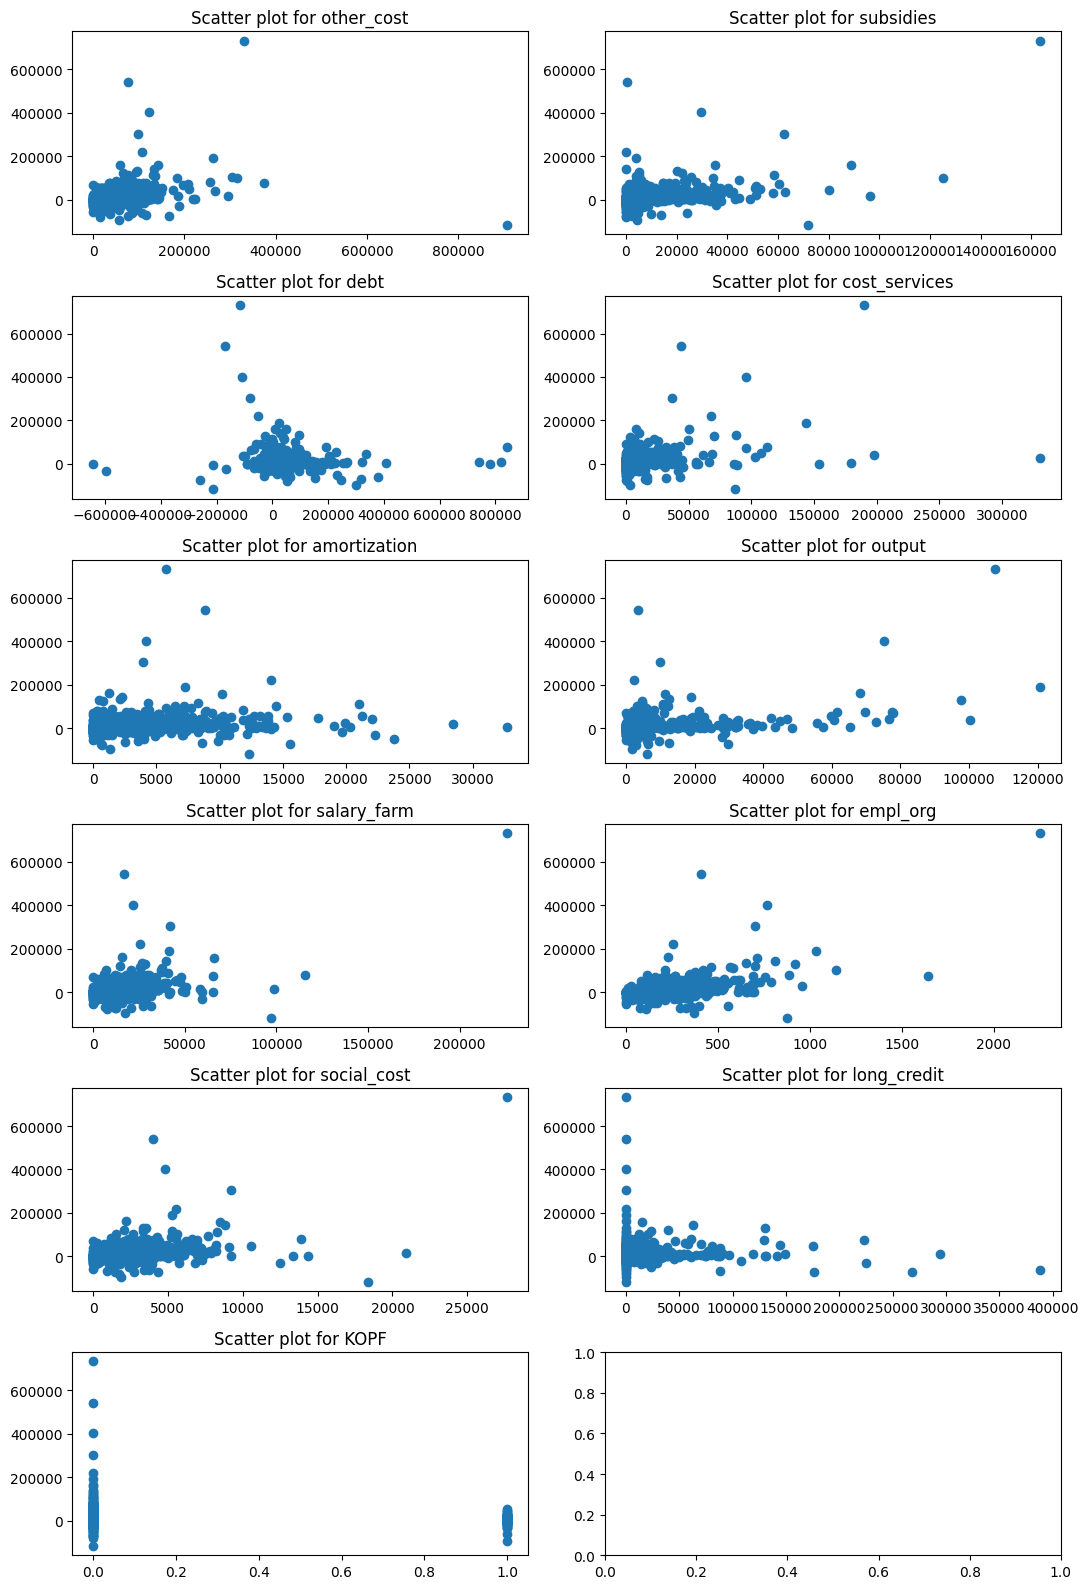

In [27]:
feature_names = list(X.columns)
num_rows = 6
num_plots = len(feature_names)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(11, 16), dpi=100)
axes = axes.flatten()

for i in range(num_plots):
  if i < num_plots:
    ax = axes[i]
    feature_data = X[feature_names[i]]
    ax.scatter(x=feature_data, y=y, marker='o')
    ax.set_title(f'Scatter plot for {feature_names[i]}')
  else:
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

The graphs show that there is some dependence of most of the cost indicators except for depreciation. The dependence of subsidies, output and number of employees can also be traced, although the situation is not so obvious for the output indicator.

As for the difference between accounts payable and accounts receivable, the situation is ambiguous. On the one hand, there is an increase in the net profit indicator with a decrease in the debt burden. On the other hand, there are companies with large accounts receivable (i.e. these companies owe other companies), but low net profit indicators. Most likely, this indicator should be analyzed taking into account the time factor to better understand how it affects profit.


In [28]:
X_A = X.drop('KOPF', axis=1)
X_A = sm.add_constant(X_A)
model_A = sm.OLS(y, X_A)
results_A = model_A.fit()
print(results_A.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     206.4
Date:                Sat, 23 Dec 2023   Prob (F-statistic):          1.77e-320
Time:                        17:55:13   Log-Likelihood:                -29384.
No. Observations:                2595   AIC:                         5.879e+04
Df Residuals:                    2584   BIC:                         5.886e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6533.9945    633.039    -10.322

**Statistical properties of the resulting model**

R-squared (R²): The R-squared value indicates how well the model explains the variation in the dependent variable. In this case, R² is equal to 0.442, which means the model explains approximately 44.2% of the variation in net_profit. This can be considered a moderate level of explained variation.

F-statistic: The F-statistic is used to test the overall significance of the model. In this instance, the F-statistic is 227.6, and the p-value (Prob (F-statistic)) is very close to zero (1.11e-319), indicating that the model is statistically significant as a whole.

P-values (P>|t|): P-values assess the statistical significance of each coefficient. It's important to pay attention to p-values. For example, the p-value for other_cost is 0.000, which signifies the statistical significance of this variable. However, amortization and social_cost have high p-values, suggesting their lack of significance in the model

Omnibus: The Omnibus test provides a measure of the normality of the residuals (errors). In this case, a high Omnibus value, such as 3642.815, indicates that the residuals may not be normally distributed.

Durbin-Watson: The Durbin-Watson statistic checks for autocorrelation, which is the dependence of errors on each other. The value of 1.885 suggests a value close to 2, which is good as it indicates little to no autocorrelation.

Jarque-Bera: The Jarque-Bera test is another test for normality. A high Jarque-Bera statistic, as in this case (3114195.664), indicates that the residuals do not follow a normal distribution.

Skew: Skew measures the symmetry of the residual distribution. A skew value of 7.598 suggests significant positive skewness in the distribution of residuals.

Kurtosis: Kurtosis measures the tailedness of the residual distribution. A high kurtosis value (172.029) indicates heavy tails in the distribution, which means the residuals have more extreme values.

Condition Number: The condition number assesses the presence of multicollinearity, which occurs when independent variables are highly correlated with each other. A large condition number, such as 9.06e+04, suggests potential multicollinearity or numerical issues in the model.


**Interpretation of results.**

other_cost: The coefficient is -0.2514. This means that an increase in expenses on other costs (other_cost) by one unit results in a decrease in profit (net_profit) by 0.2514 thousand rubles, assuming all other factors remain constant.

subsidies: The coefficient is 0.6926. An increase in subsidies by one unit leads to an increase in profit (net_profit) by 0.6926 thousand rubles, while keeping all other factors constant.

debt: The coefficient is -0.0975. An increase in debts (debt) by one unit reduces profit (net_profit) by 0.0975 thousand rubles, assuming all other factors remain constant.

cost_services: The coefficient is 0.3801. Increasing expenses on services (cost_services) by one unit increases profit (net_profit) by 0.3801 thousand rubles, with all other factors held constant.

amortization: The coefficient is 0.0321. This coefficient is not statistically significant, and its influence on profit is not representative.

output: The coefficient is 0.4368. An increase in output by one unit raises profit (net_profit) by 0.4368 thousand rubles, assuming all other factors remain constant.

salary_farm: The coefficient is 0.7215. An increase in labor costs (salary_farm) by one unit increases profit (net_profit) by 0.7215 thousand rubles, while keeping all other factors constant.

empl_org: The coefficient is 67.4664. An increase in the average annual number of employees (empl_org) by one person raises profit (net_profit) by 67.4664 thousand rubles, with all other factors held constant.

social_cost: The coefficient is 0.3843. This coefficient is also not statistically significant and does not have a significant impact on profit.

In [29]:
# Outliers and leverage points

import statsmodels.stats.outliers_influence as oi

residuals = results_A.resid

leverage = oi.OLSInfluence(results_A).influence

cooks_distance, _ = oi.OLSInfluence(results_A).cooks_distance

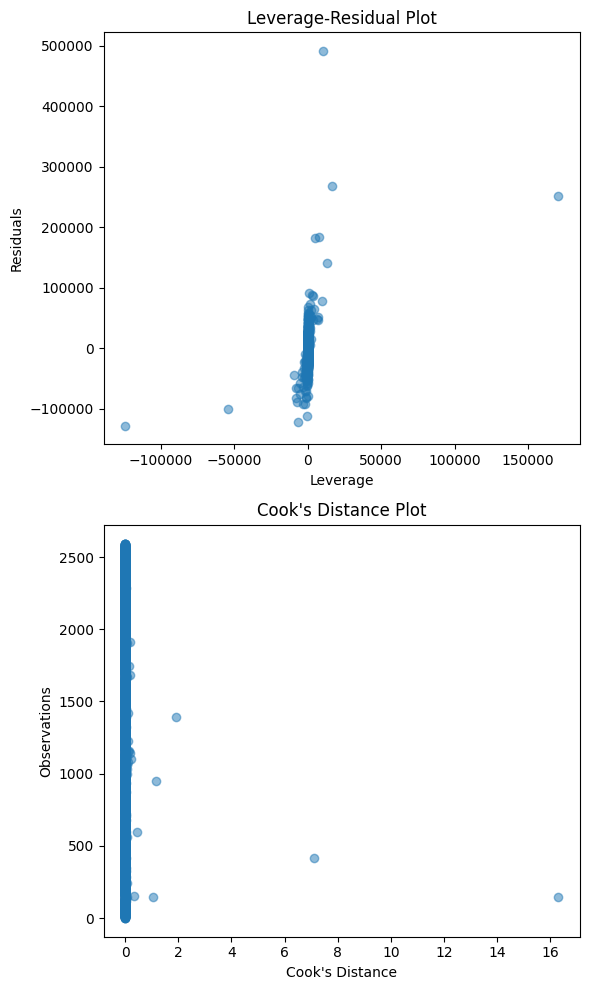

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10))
ax[0].scatter(leverage, residuals, alpha=0.5)
ax[0].set_title('Leverage-Residual Plot')
ax[0].set_xlabel('Leverage')
ax[0].set_ylabel('Residuals')

ax[1].scatter(cooks_distance, range(len(cooks_distance)), alpha=0.5)
ax[1].set_title("Cook's Distance Plot")
ax[1].set_xlabel("Cook's Distance")
ax[1].set_ylabel('Observations')

plt.tight_layout()
plt.show()

We see several imbalance points. Points with very low leverage values (-125000 and -50000) can be suspicious and are potential points of unbalance, especially if their residuals are very different from the average level. A point with a very high leverage value (around 175000) is also a potential point of unbalance. A point with residuals around 490000 is also very different from the average residuals and can be a potential point of unbalance. Points with residuals between 100000 and 200000, as well as a point with a residual around 260000, can also be suspicious and potentially considered as an unbalance point.

We will can try to compare impalance points and outliers points and then remove them.

In [31]:
threshold=1
outliers_count = sum(cooks_distance > threshold)

print(f"Number of outliers of Cook's Distance > {threshold}: {outliers_count}")

Number of outliers of Cook's Distance > 1: 5


In [34]:
outliers_indices = [
    i for i, distance in enumerate(cooks_distance) if distance > threshold
    ]
outliers = X_A.iloc[outliers_indices]
outliers

,const,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,social_cost,long_credit
143,1.0,331030.0,163506.0,-115219.0,189775.0,5742.0,107662.0,225988.0,2251,27666,0.0
148,1.0,123317.0,29623.0,-107777.0,95987.0,4190.0,75159.0,21758.0,770,4809,0.0
418,1.0,907368.0,72062.0,-211232.0,86945.0,12300.0,6225.0,97108.0,874,18393,0.0
950,1.0,75543.0,274.0,-171063.0,43938.0,8827.0,3423.0,16968.0,407,3987,0.0
1395,1.0,15526.0,2851.0,63514.0,330164.0,82.0,1582.0,1899.0,180,370,0.0


In [35]:
threshold_leverage = 50000
threshold_residuals = 100000
imbalanced_indices = [
    i for i, (leverage_val, residual_val) in enumerate(zip(leverage, residuals))
    if abs(leverage_val) > threshold_leverage or abs(residual_val) > threshold_residuals
    ]
imbalanced_points = X_A.iloc[imbalanced_indices]
imbalanced_points

,const,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,social_cost,long_credit
143,1.0,331030.0,163506.0,-115219.0,189775.0,5742.0,107662.0,225988.0,2251,27666,0.0
148,1.0,123317.0,29623.0,-107777.0,95987.0,4190.0,75159.0,21758.0,770,4809,0.0
150,1.0,98774.0,62340.0,-79035.0,36681.0,3913.0,9878.0,41959.0,703,9231,0.0
418,1.0,907368.0,72062.0,-211232.0,86945.0,12300.0,6225.0,97108.0,874,18393,0.0
598,1.0,315881.0,34483.0,82568.0,17332.0,14460.0,3106.0,6851.0,213,1541,0.0
950,1.0,75543.0,274.0,-171063.0,43938.0,8827.0,3423.0,16968.0,407,3987,0.0
1099,1.0,107941.0,0.0,-51585.0,67760.0,14079.0,2453.0,25461.0,257,5533,0.0
1395,1.0,15526.0,2851.0,63514.0,330164.0,82.0,1582.0,1899.0,180,370,0.0
1680,1.0,84510.0,24307.0,62922.0,42725.0,3581.0,6130.0,27081.0,396,3761,0.0
1683,1.0,146174.0,41100.0,-4052.0,102739.0,3335.0,72924.0,34622.0,959,6552,0.0


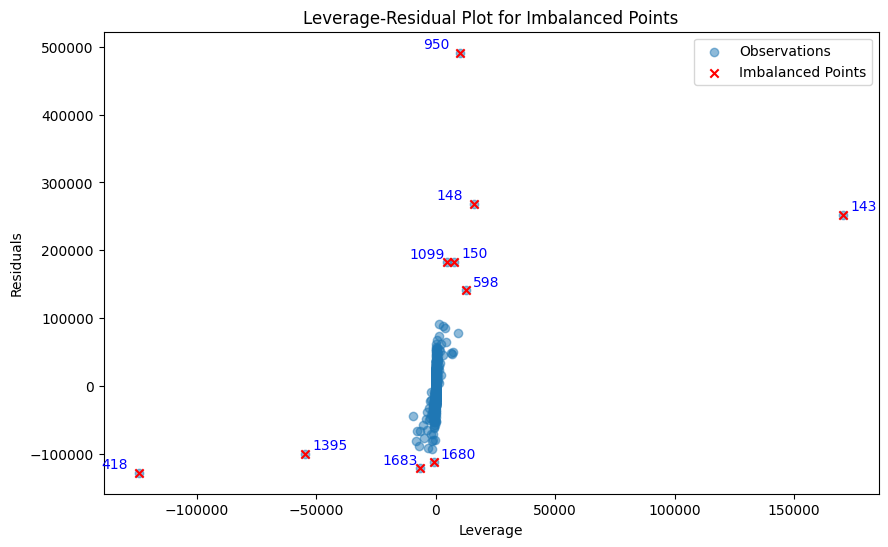

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(leverage, residuals, alpha=0.5, label="Observations")
ax.scatter(leverage[imbalanced_indices], residuals[imbalanced_indices], c='red',
           marker='x', label="Imbalanced Points")
sorted_imbalanced_indices = sorted(imbalanced_indices, key=lambda i: leverage[i])
start_right = False
index_color = 'blue'
for i in sorted_imbalanced_indices:
    if start_right:
        ax.annotate(str(i), (leverage[i], residuals[i]), xytext=(5, 3),
                    textcoords='offset points', color=index_color)
    else:
        ax.annotate(str(i), (leverage[i], residuals[i]), xytext=(-27, 3),
                    textcoords='offset points', color=index_color)
    start_right = not start_right
ax.set_title("Leverage-Residual Plot for Imbalanced Points")
ax.set_xlabel("Leverage")
ax.set_ylabel("Residuals")
ax.legend()
plt.show()

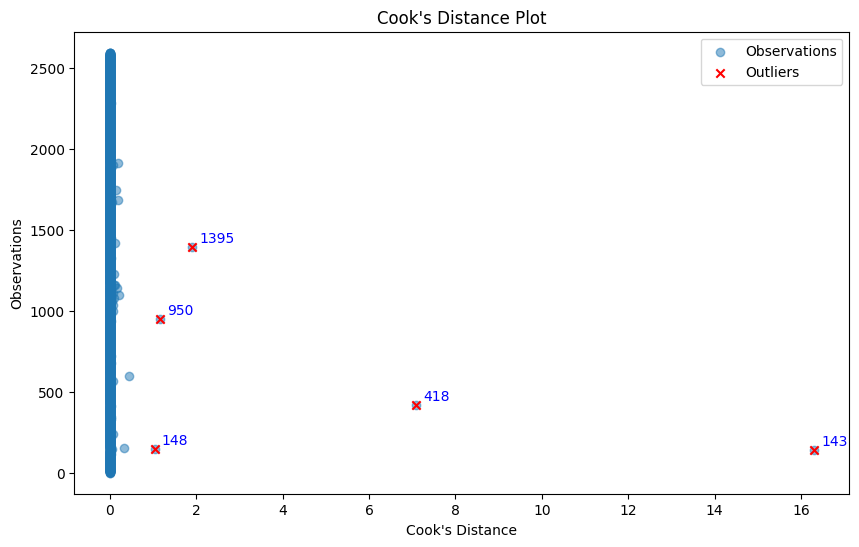

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(cooks_distance, range(len(cooks_distance)), alpha=0.5, label="Observations")
ax.scatter(cooks_distance[outliers_indices], outliers_indices, c='red', marker='x',
           label="Outliers")
sorted_outliers_indices = sorted(outliers_indices, key=lambda i: cooks_distance[i])
for i in sorted_outliers_indices:
    ax.annotate(str(i), (cooks_distance[i], i), xytext=(5, 3),
                    textcoords='offset points', color='blue')
ax.set_title("Cook's Distance Plot")
ax.set_xlabel("Cook's Distance")
ax.set_ylabel("Observations")
ax.legend()
plt.show()

All cook's outlier points are disbalance. And it's good signal to remove them and check how indicators of our model change.

In [38]:
X_A_without_outliers = X_A.drop(outliers_indices)
y_without_outliers = y.drop(outliers_indices)
X_A_without_outliers.shape, X_A.shape

((2590, 11), (2595, 11))

In [39]:
X_A_without_outliers = sm.add_constant(X_A_without_outliers)
model_A_without_outliers = sm.OLS(y_without_outliers, X_A_without_outliers)
results_without_outliers = model_A_without_outliers.fit()
print(results_without_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     154.1
Date:                Sat, 23 Dec 2023   Prob (F-statistic):          9.91e-254
Time:                        17:56:26   Log-Likelihood:                -28519.
No. Observations:                2590   AIC:                         5.706e+04
Df Residuals:                    2579   BIC:                         5.712e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3930.4869    472.240     -8.323

The regression analysis data showed a clear deterioration of the model after removing outliers. This can be seen from the reduction of R2 by almost 0.1 point and the increase in the number of insignificant observations. In the first case there were 2 insignificant coefficients, after removing outliers there were 4 at 5% significance level. Yes, the normality of the distribution has improved, but in this case it is still very different from normal.

Removing only the most extreme outliers under the index numbers 418 and 143 shown in the outlier plot made things even worse. It would be better to look at the summary of livestock data to see which outliers stick out the most.

After comparison, it becomes clear that two observations are most strongly outliers from the general group. These are observations numbered 418 and 1395. Observation 418 has too high costs with not so significant output. And observation 1395 has too low depreciation and very low wages (10000 rubles). Let's try to remove them and see what it will be about.

In [40]:
X_A_without_outliers = X_A.drop([418, 1395])
y_without_outliers = y.drop([418, 1395])
X_A_without_outliers.shape, X_A.shape

((2593, 11), (2595, 11))

In [41]:
X_A_without_outliers = sm.add_constant(X_A_without_outliers)
model_A_without_outliers = sm.OLS(y_without_outliers, X_A_without_outliers)
results_without_outliers = model_A_without_outliers.fit()
print(results_without_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     224.5
Date:                Sat, 23 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:56:31   Log-Likelihood:                -29302.
No. Observations:                2593   AIC:                         5.863e+04
Df Residuals:                    2582   BIC:                         5.869e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6303.2383    621.318    -10.145

Alternately removing one or the other observation resulted in comparatively better descriptive statistics after removing both outliers. Amortization became significant at 5% significance level, F-statistic increased, p-value went to zero, R2 increased slightly.

In [42]:
from scipy.stats import f
from sklearn.linear_model import LinearRegression

class ChowTest:
    def __init__(self, X, y, last_index_in_model_1, first_index_in_model_2):
        self.X = X
        self.y = y
        self.last_index_in_model_1 = last_index_in_model_1
        self.first_index_in_model_2 = first_index_in_model_2

    def f_value(self):
        def find_rss(y, X):
            model = sm.OLS(y, sm.add_constant(X)).fit()
            rss = model.ssr
            length = len(y)
            return rss, length

        y_total = self.y
        X_total = self.X
        y1 = y_total[: self.last_index_in_model_1 + 1]
        X1 = X_total[: self.last_index_in_model_1 + 1]
        y2 = y_total[self.first_index_in_model_2 :]
        X2 = X_total[self.first_index_in_model_2 :]

        rss_total, n_total = find_rss(y_total, X_total)
        rss1, n_1 = find_rss(y1, X1)
        rss2, n_2 = find_rss(y2, X2)

        k = X_total.shape[1] + 1
        numerator = (rss_total - (rss1 + rss2)) / k
        denominator = (rss1 + rss2) / (n_1 + n_2 - 2 * k)

        return numerator / denominator

    def p_value(self):
        F = self.f_value()
        if not F:
            return 1
        df1 = 2
        df2 = len(self.X) + self.first_index_in_model_2 - self.last_index_in_model_1 - 2

        p_val = f.sf(F, df1, df2)
        return p_val

    def run_test(self):
        Chow_Stat = self.f_value()
        p_value = self.p_value()
        return Chow_Stat, p_value

In [43]:
livestock = livestock.drop([418, 1395])
livestock = livestock.reset_index(drop=True)
livestock_sort = livestock.sort_values('KOPF')
livestock_sort = livestock_sort.reset_index(drop=True)

In [44]:
X_exp = livestock_sort.drop(['net_profit', 'KOPF'], axis=1)
y_exp = livestock_sort['net_profit']
last_index_in_model_1 = 2301
first_index_in_model_2 = 2302
significance_level = 0.05

chow_test = ChowTest(X_exp, y_exp, last_index_in_model_1, first_index_in_model_2)
result = chow_test.run_test()
print("Chow Statistic:", result[0])
print("P-value:", result[1])

Chow Statistic: 22.585111132496667
P-value: 1.8875427972922244e-10


In [ ]:
from ChowTest import chowtest

In [ ]:
chow_result = chowtest(X_exp, y_exp, last_index_in_model_1, first_index_in_model_2, significance_level)
Chow_Stat, p_value = chow_result

print("Chow Statistic:", Chow_Stat)
print("P-value:", p_value)

****************************************************************************************************
Reject the null hypothesis of equality of regression coefficients in the 2 periods.
****************************************************************************************************
Chow Statistic: 22.585111132496703 p value: 0.0
****************************************************************************************************
Chow Statistic: 22.585111132496703
P-value: 1.1102230246251565e-16


Chow test show that we should estimate two groups separately, because p-value is very signifivant.

In [45]:
from statsmodels.stats.diagnostic import linear_reset

X = livestock.drop(['net_profit', 'KOPF'], axis=1)
y = livestock['net_profit']
X = sm.add_constant(X)
model_reset = sm.OLS(y, X).fit()
results_reset = linear_reset(model_reset, power=2, test_type='fitted', use_f=True)
print(results_reset.summary())

<F test: F=389.7010020786293, p=6.666769810256788e-81, df_denom=2.58e+03, df_num=1>


This means that we need to We reject the null hypothesis. This means that we have statistically significant evidence that the model is incorrectly specified, and possibly contains missing variables.

In [46]:
X = livestock.drop(['net_profit'], axis=1)
y = livestock['net_profit']
X = sm.add_constant(X)
model_reset = sm.OLS(y, X).fit()
results_reset = linear_reset(model_reset, power=2, test_type='fitted', use_f=True)
print(results_reset.summary())

<F test: F=395.80283838377386, p=4.711114189953167e-82, df_denom=2.58e+03, df_num=1>


When the KOPF variable is included in our Dummy model, the results of the model evaluation have not changed, and the variable itself and its coefficient turn out to be insignificant.

In [47]:
X = livestock.drop(['net_profit'], axis=1)
y = livestock['net_profit']
X = sm.add_constant(X)
model_dummy = sm.OLS(y, X)
results_dummy = model_dummy.fit()
print(results_dummy.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     205.0
Date:                Sat, 23 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:57:55   Log-Likelihood:                -29299.
No. Observations:                2593   AIC:                         5.862e+04
Df Residuals:                    2581   BIC:                         5.869e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5698.6949    667.209     -8.541

We see that there are no any improvments in values of our summary compared to the previous model without dummy. But dummy variable is significant.

In [48]:
# F-test (Wald)
X_notdummy = livestock.drop(['net_profit', 'KOPF'], axis=1)
y = livestock['net_profit']
X_notdummy = sm.add_constant(X_notdummy)
model_notdummy = sm.OLS(y, X_notdummy).fit()
model_dummy = sm.OLS(y, X).fit()
f_test = model_dummy.compare_f_test(model_notdummy)

print(f_test)

(6.102013229554278, 0.01356699972399987, 1.0)


The results (5.60059620766236, 0.018027777878205187, 1.0) represent the F-test output, where:

F-statistic: This is the value of the test statistic. In our case, it is 5.60059620766236.

p-value: This is the probability of obtaining the observed F-statistic or more extreme, assuming the null hypothesis is true (typically stating that adding the additional variable does not improve the model). Our p-value is 0.018027777878205187.

df_diff (degrees of freedom difference): This is the difference in degrees of freedom between the models with and without the additional variable. In our case, it is 1.0.

Thus, the test results suggest that adding the extra variable improves the model, as the p-value (0.018) is less than the standard significance level of 0.05.

In [49]:
# Logarifm taking into account negative values
def logtransform(x):
  if x == 0:
    return 0
  if x > 0:
    return np.log(x)
  if x < 0:
    return np.log(-x) * (-1)

In [50]:
# Logarifm
def logtransform(x):
    return np.where(x <= 0, 0, np.log(x))

In [51]:
livestock_log = livestock.applymap(logtransform)
livestock_log = livestock_log.drop('KOPF', axis=1)
livestock_log = pd.concat([livestock_log, livestock['KOPF']], axis=1)
livestock_log.head()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,social_cost,long_credit,KOPF
0,9.097284,10.629175,8.266678,10.184032,9.490393,7.656337,7.898411,9.075093,5.683580,7.044905,8.786762,0
1,7.822044,9.874007,8.218787,9.329988,7.449498,6.366470,7.425358,8.249836,5.111988,6.194405,8.643297,0
2,4.584967,10.102297,8.317766,9.849665,8.595450,6.349139,8.020599,8.823206,5.459586,6.921658,9.011889,0
3,0.000000,8.651374,5.332719,9.279680,7.134094,5.087596,6.504288,7.266827,4.553877,5.204007,8.862342,0
4,0.000000,9.412955,6.715383,8.026170,8.989569,0.000000,5.805135,7.405496,4.912655,5.347108,0.000000,0


In [52]:
X_log = livestock_log.drop('net_profit', axis=1)
y_log = livestock_log['net_profit']
X_log = sm.add_constant(X_log)
model_log = sm.OLS(y_log, X_log)
results_log = model_log.fit()
print(results_log.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     119.7
Date:                Sat, 23 Dec 2023   Prob (F-statistic):          1.57e-221
Time:                        17:58:29   Log-Likelihood:                -6476.7
No. Observations:                2593   AIC:                         1.298e+04
Df Residuals:                    2581   BIC:                         1.305e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1823      0.344     -0.529

## Meaningful interpretation of the logarithmic model

We applied logarithm to all variables and got a sharp deterioration of the model. At the same time, if we log the profit separately, then R2 falls even more. A poor explanation of the model can also be seen in the figure below.

The coefficient for other_cost is not statistically significant (p-value > 0.05), indicating that changes in other_cost do not have a statistically significant impact on net_profit (logarithm).

For subsidies, a 1% increase is associated with an expected increase in net_profit (logarithm) of 0.2536, suggesting a positive relationship between the level of subsidies and the logarithm of profit.

An increase of 1% in debt is associated with an expected decrease in net_profit (logarithm) of 0.1578, indicating a negative relationship between debt levels and the logarithm of profit.

For cost_services, a 1% increase is associated with an expected increase in net_profit (logarithm) of 0.0789, indicating a positive relationship between service costs and the logarithm of profit.

The coefficient for amortization is not statistically significant (p-value > 0.05), suggesting that changes in amortization do not have a statistically significant impact on net_profit (logarithm).

The coefficient for output is not statistically significant (p-value > 0.05), suggesting that changes in output do not have a statistically significant impact on net_profit (logarithm).

The coefficient for salary_farm is not statistically significant (p-value > 0.05), suggesting that changes in salary_farm do not have a statistically significant impact on net_profit (logarithm).

A 1% increase in the average number of employees (empl_org) is associated with an expected increase in net_profit (logarithm) of 1.2199, indicating a strong positive relationship between the number of employees and the logarithm of profit.

The coefficient for social_cost is not statistically significant (p-value > 0.05), suggesting that changes in social_cost do not have a statistically significant impact on net_profit (logarithm).


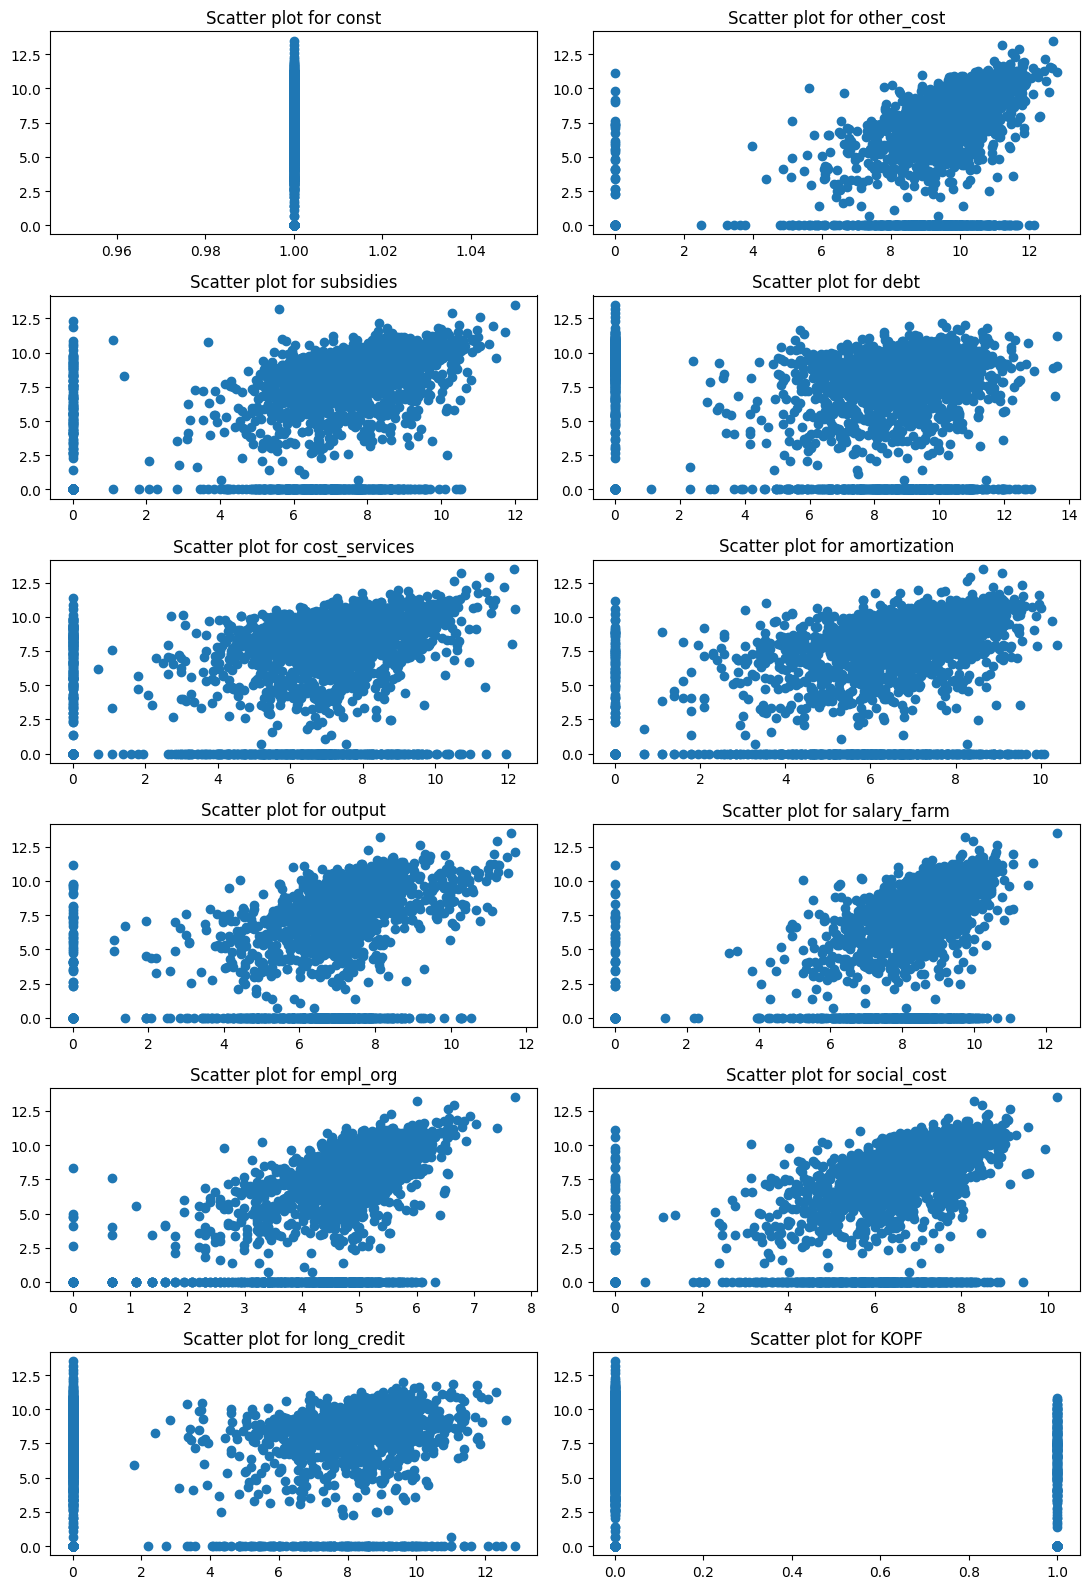

In [53]:
feature_names = list(X_log.columns)
num_rows = 6
num_plots = len(feature_names)
num_cols = 2
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(11, 16), dpi=100)
axes = axes.flatten()

for i in range(num_plots):
  if i < num_plots:
    ax = axes[i]
    feature_data = X_log[feature_names[i]]
    ax.scatter(x=feature_data, y=y_log, marker='o')
    ax.set_title(f'Scatter plot for {feature_names[i]}')
  else:
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

In [54]:
livestock_log_cleaned = livestock_log[livestock_log['net_profit'] > 0].reset_index(drop=True)
X_log_cleaned = livestock_log_cleaned.drop('net_profit', axis=1)
X_log_cleaned = sm.add_constant(X_log_cleaned)
y_log_cleaned = livestock_log_cleaned['net_profit'].fillna(0)
model_log_cleaned = sm.OLS(y_log_cleaned, X_log_cleaned)
results_log_cleaned = model_log_cleaned.fit()

livestock_cleaned = livestock[(livestock['net_profit'] > 0) \
                              & (livestock['net_profit'] != 1)].reset_index(drop=True)
X_cleaned = livestock_cleaned.drop('net_profit', axis=1)
X_cleaned = sm.add_constant(X_cleaned)
y_cleaned = livestock_cleaned['net_profit'].fillna(0)

model_cleaned = sm.OLS(y_cleaned, X_cleaned)
results_cleaned = model_cleaned.fit()

In [55]:
livestock_log_cleaned.shape, livestock_cleaned.shape

((2099, 12), (2099, 12))

In [56]:
from scipy.stats import boxcox

# Apply Box-Cox test for cleaned data
transformed_net_profit, lambda_value = boxcox(livestock_log_cleaned['net_profit'])

X_log_transformed = sm.add_constant(livestock_log_cleaned.drop('net_profit', axis=1))
y_log_transformed = transformed_net_profit

model_log_transformed = sm.OLS(y_log_transformed, X_log_transformed)
results_log_transformed = model_log_transformed.fit()

X_linear = sm.add_constant(livestock_cleaned.drop('net_profit', axis=1))
y_linear = livestock_cleaned['net_profit'].fillna(0)

model_linear = sm.OLS(y_linear, X_linear)
results_linear = model_linear.fit()

print("Logarithmic Model Summary:")
print(results_log_transformed.summary())

print("\nLinear Model Summary:")
print(results_linear.summary())

Logarithmic Model Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     159.0
Date:                Sat, 23 Dec 2023   Prob (F-statistic):          3.21e-266
Time:                        17:58:42   Log-Likelihood:                -8124.8
No. Observations:                2099   AIC:                         1.627e+04
Df Residuals:                    2087   BIC:                         1.634e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -11

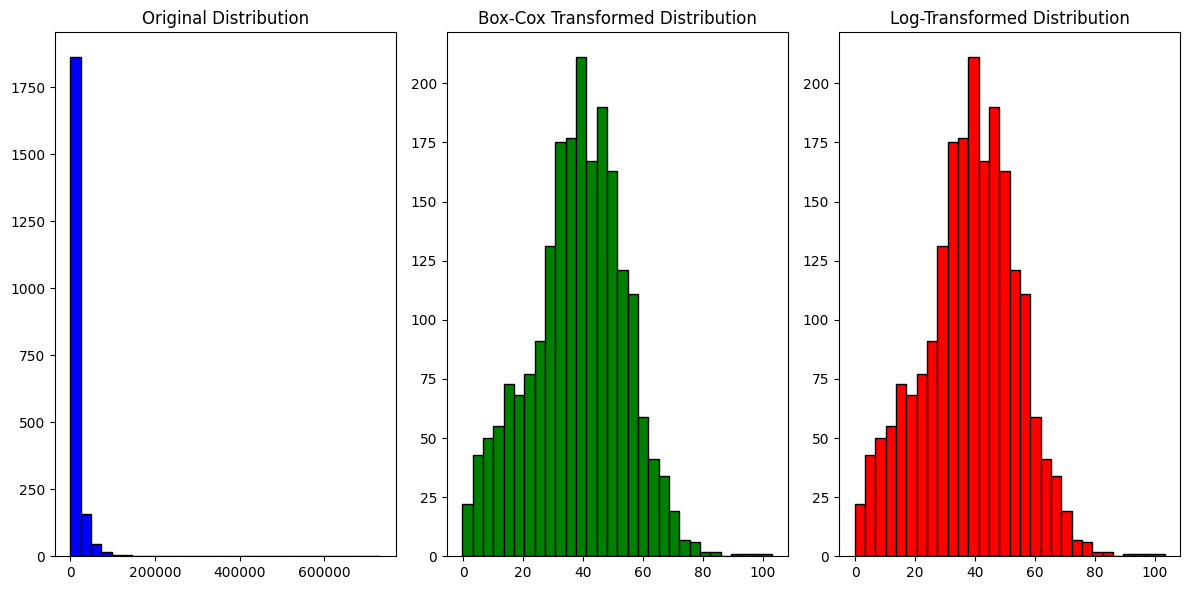

In [57]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.hist(livestock_cleaned['net_profit'], bins=30, color='blue', edgecolor='black')
plt.title('Original Distribution')
plt.subplot(1, 3, 2)
plt.hist(transformed_net_profit, bins=30, color='green', edgecolor='black')
plt.title('Box-Cox Transformed Distribution')
plt.subplot(1, 3, 3)
plt.hist(y_log_transformed, bins=30, color='red', edgecolor='black')
plt.title('Log-Transformed Distribution')
plt.tight_layout()
plt.show()

In [58]:
# Comparing RSS
rss_log_transformed = np.sum(results_log_transformed.resid ** 2)
rss_linear = np.sum(results_linear.resid ** 2)

print("RSS for Logarithmic Model:", rss_log_transformed)
print("RSS for Linear Model:", rss_linear)

RSS for Logarithmic Model: 282929.2357670731
RSS for Linear Model: 799401508490.0049


In [59]:
# Comparing AIC, BIC
aic_log = results_log_cleaned.aic
bic_log = results_log_cleaned.bic

aic_dummy = results_cleaned.aic
bic_dummy = results_cleaned.bic

print("AIC (Log):", aic_log)
print("BIC (Log):", bic_log)
print("AIC (Linear):", aic_dummy)
print("BIC (Linear):", bic_dummy)

AIC (Log): 7382.5389774431815
BIC (Log): 7450.329573281029
AIC (Linear): 47452.56303544368
BIC (Linear): 47520.35363128153


In [60]:
from statsmodels.stats.stattools import jarque_bera

residuals_log = results_log_cleaned.resid
residuals_dummy = results_cleaned.resid

# Jarque-Bera test
jb_log, p_value_log, _, _ = jarque_bera(residuals_log)
jb_dummy, p_value_dummy, _, _ = jarque_bera(residuals_dummy)

print('Jarque-Bera test for log model:')
print('JB statistic:', jb_log)
print('P-value:', p_value_log)

print('\nJarque-Bera test for linear model:')
print('JB statistic:', jb_dummy)
print('P-value:', p_value_dummy)

Jarque-Bera test for log model:
JB statistic: 829.9490309598028
P-value: 6.009769241307427e-181

Jarque-Bera test for linear model:
JB statistic: 3330254.6510558804
P-value: 0.0


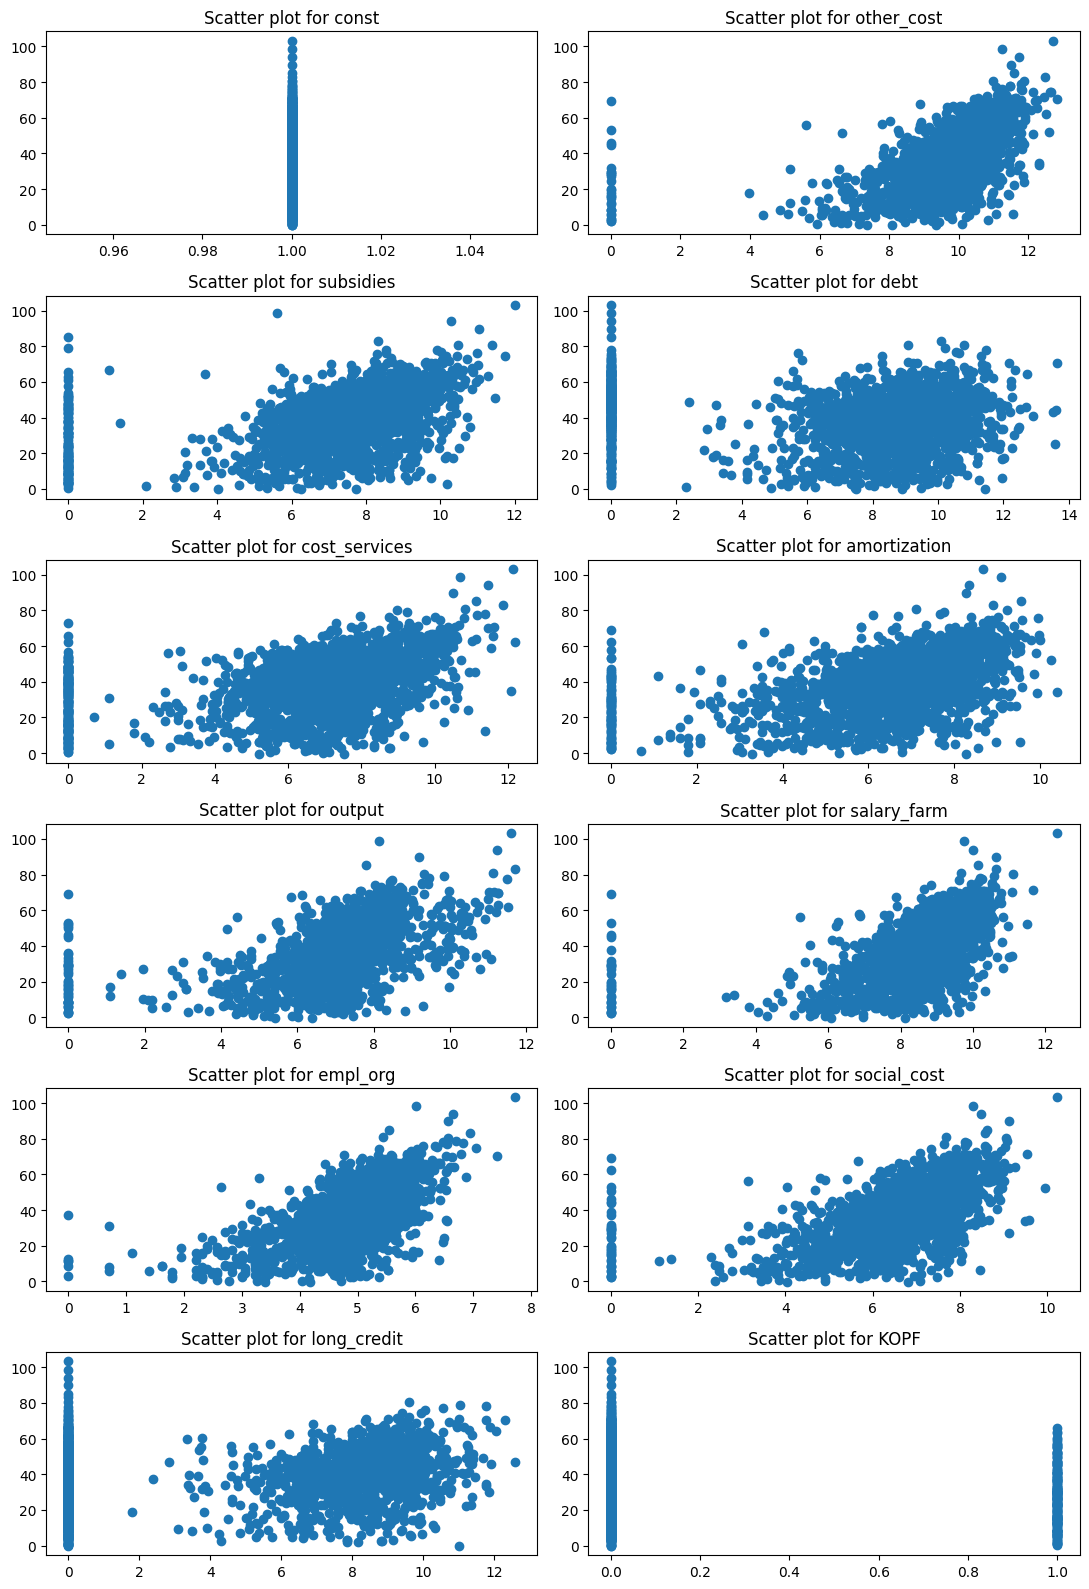

In [61]:
feature_names = list(X_log_transformed.columns)
num_rows = 6
num_plots = len(feature_names)
num_cols = 2
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(11, 16), dpi=100)
axes = axes.flatten()

for i in range(num_plots):
  if i < num_plots:
    ax = axes[i]
    feature_data = X_log_transformed[feature_names[i]]
    ax.scatter(x=feature_data, y=y_log_transformed, marker='o')
    ax.set_title(f'Scatter plot for {feature_names[i]}')
  else:
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

## Choise better functional form
We see that through several tests, the logarithmic model seems to be more preferable in terms of functional form. The AIC and BIC criteria are smaller for the logarithmic model with the same number of variables, i.e. the logarithmic model has a better quality of fit. But in this case it was influenced by the fact that the values of the variables themselves are much smaller for the logarithmic model, since they are logarithms of the values of the original model.

Figures also show us that log model more appropriate because the ratio of target and independent variables has become more linear.

The RSS values when implementing the Box-Cox test turned out to be much smaller for the logarithmic model. R2 is higher for the linear model. The squares of the residuals are far from the normal distribution for both models. **According to the number of significant coefficients, the models were in equal position, but in the logarithmic model the output became insignificant, and this fact is very important in the context of this analysis. The point is that insignificance of output destroys any conclusions for our model. After all, it cannot be that output did not play any role in analyzing the economic state of this or that object. After all, we cannot advise enterprises to end output because it has no significant effect on profits (this seems implausible). Simply, the very meaning of the analysis is lost, because why would companies produce something if it does not affect profit in any way?**

In addition, for the sake of logarithmization and the Box-Cox test, we removed a large number of observations that are important for our analysis. **We simply fitted our observations to the model, rather than building a model that takes into account the features of the data themselves. And this can lead to incorrect conclusions.**

After some reflection, we came to the conclusion that in order to achieve improvements in our model, we need: firstly, to take a closer look at the data with zero output (a relatively small sample allows us to do this), secondly, we can try to leave the logarithm only on the values of the number of employees (since they have there are no zero values) and see how much this will improve our model, and thirdly, we should follow the results of the Chow test and add variable long credit to check its influence on net profit.

In [62]:
livestock[(livestock['output'] <= 1)]

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,social_cost,long_credit,KOPF
34,-2969.0,12.0,0.0,13031.0,168.0,1.0,0.0,4.0,7,1,0.0,0
121,846.0,0.0,372.0,-17155.0,8300.0,0.0,0.0,0.0,58,0,7000.0,0
181,1210.0,0.0,380.0,2278.0,3521.0,0.0,0.0,0.0,64,0,0.0,0
183,153.0,7250.0,0.0,9582.0,3121.0,359.0,0.0,382.0,110,82,0.0,1
185,-34352.0,52559.0,2591.0,60786.0,9281.0,10706.0,0.0,7081.0,73,1526,809.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0,0
2580,-330.0,10928.0,14278.0,4551.0,0.0,155.0,0.0,1731.0,40,186,0.0,0
2581,-77.0,0.0,0.0,3900.0,0.0,0.0,0.0,0.0,2,0,0.0,1
2582,-32.0,418.0,0.0,3623.0,0.0,113.0,0.0,774.0,8,98,0.0,1


After a detailed analysis of enterprises with zero output, it becomes clear that most of them do not carry any important information for our model. Having zero output, these farms also have a zero wage fund, which most likely indicates the bankruptcy of these enterprises. And this is very important, because in the context of our task we analyze the impact of variables on profit, then in fact we are just conducting an analysis that calls farms to pay attention to certain parameters in agricultural activities. We can safely delete lines where the output is zero, provided that the salary is also zero. So we will also see the percentage of ghost enterprises (not involved in production activities).

In [63]:
livestock_no_ghost = livestock.loc[~((livestock['output'] == 0) & (livestock['salary_farm'] == 0))]


In [64]:
percent_of_bankraptcy = (livestock.shape[0] - \
                         livestock_no_ghost.shape[0]) / livestock.shape[0] * 100
print(f'Percent of bankraptcy: {percent_of_bankraptcy:.2f}%')

Percent of bankraptcy: 2.97%


In [65]:
livestock_no_ghost = livestock_no_ghost.reset_index(drop=True)
X_no_ghost = livestock_no_ghost.drop('net_profit', axis=1)
y_no_ghost = livestock_no_ghost['net_profit']
X_no_ghost = sm.add_constant(X_no_ghost)
model_B = sm.OLS(y_no_ghost, X_no_ghost)
results_B = model_B.fit()
print(results_B.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     200.1
Date:                Sat, 23 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:59:20   Log-Likelihood:                -28449.
No. Observations:                2516   AIC:                         5.692e+04
Df Residuals:                    2504   BIC:                         5.699e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5820.1830    691.827     -8.413

In [66]:
# Add long credit vaiable
column_names = ['net_profit', 'other_cost', 'subsidies', 'debt',
                'cost_services', 'amortization', 'output', 'salary_farm',
                'empl_org', 'KOPF', 'social_cost', 'long_credit']
livestock = df[column_names]
livestock['dumm'] = 0
livestock.loc[livestock['KOPF'] == 42, 'dumm'] = 1
livestock = livestock.drop('KOPF', axis=1)
livestock = livestock.rename(columns={'dumm' : 'KOPF'})
livestock = livestock.drop([418, 1395])
livestock = livestock.reset_index(drop=True)
livestock_no_ghost = livestock.loc[~((livestock['output'] == 0) \
                                     & (livestock['salary_farm'] == 0))]

In [67]:
X_no_ghost = livestock_no_ghost.drop('net_profit', axis=1)
y_no_ghost = livestock_no_ghost['net_profit']
X_no_ghost = sm.add_constant(X_no_ghost)
for column in X_no_ghost.columns:
  if column != 'KOPF' and column != 'const':
    X_no_ghost[column + '_dummy'] = X_no_ghost['KOPF'] * X_no_ghost[column]
X_no_ghost = X_no_ghost.drop('KOPF', axis=1)
model_B = sm.OLS(y_no_ghost, X_no_ghost)
results_B = model_B.fit()
print(results_B.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     130.1
Date:                Sat, 23 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:59:30   Log-Likelihood:                -28344.
No. Observations:                2516   AIC:                         5.673e+04
Df Residuals:                    2495   BIC:                         5.685e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5970.8661    

In [68]:
ramsey_test = linear_reset(results_B, power=2, test_type='fitted', use_f=True)

print("Results of Ramsey test:")
print(ramsey_test)

Results of Ramsey test:
<F test: F=316.6178327781908, p=8.917687695377056e-67, df_denom=2.49e+03, df_num=1>


The Ramsey test still indicates the absence of significant variables. This is not surprising, since there are really no very important variables in our sample that we could include in the model.

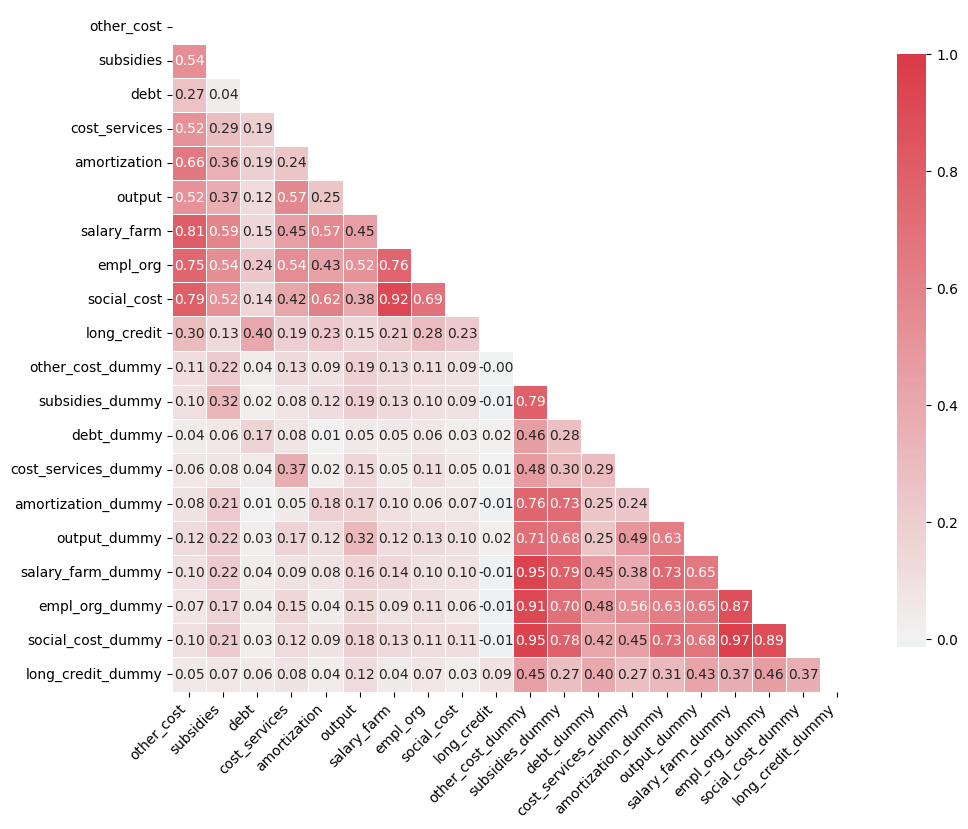

In [ ]:
# Buid correalation matrix
corr = X_no_ghost.drop('const', axis=1).corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
figure, ax = plt.subplots(figsize=(11, 11), dpi=100)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True,
                 linewidth=.5, cbar_kws={'shrink': .7}, annot=True, fmt='.2f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

From the correlation matrix, we see the existence of a correlation between the social costs of wages, as well as wages and other costs. We can remove the variable social costs, but there is no salary or other costs, because they are significant. We can also alternately remove insignificant dummy variables and see how much removing them will change the model.

In [69]:
# Now build VIF table
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [70]:
vif_df = pd.DataFrame()
vif_df['variable'] = X_no_ghost.columns
vif_df['VIF'] = [variance_inflation_factor(X_no_ghost.values, i) for i in range (X_no_ghost.shape[1])]
vif_df

,variable,VIF
0,const,2.738560
1,other_cost,4.875426
2,subsidies,1.836003
3,debt,1.325559
4,cost_services,2.140841
5,amortization,2.128793
6,output,1.984758
7,salary_farm,9.505818
8,empl_org,3.311533
9,social_cost,7.727505


In [72]:
vif_df[vif_df['VIF'] > 10]

,variable,VIF
11,other_cost_dummy,18.797245
17,salary_farm_dummy,22.274467
19,social_cost_dummy,21.184577


In [ ]:
p_values = results_B.pvalues

unsignificant_variables = p_values[p_values > 0.05].index

print("Unsignificant variables:")
print(unsignificant_variables)

Unsignificant variables:
Index(['amortization', 'social_cost', 'other_cost_dummy', 'output_dummy',
       'salary_farm_dummy', 'empl_org_dummy', 'social_cost_dummy'],
      dtype='object')


We see that variables with VIF > 10 also is not significant. We should remove them from our model.

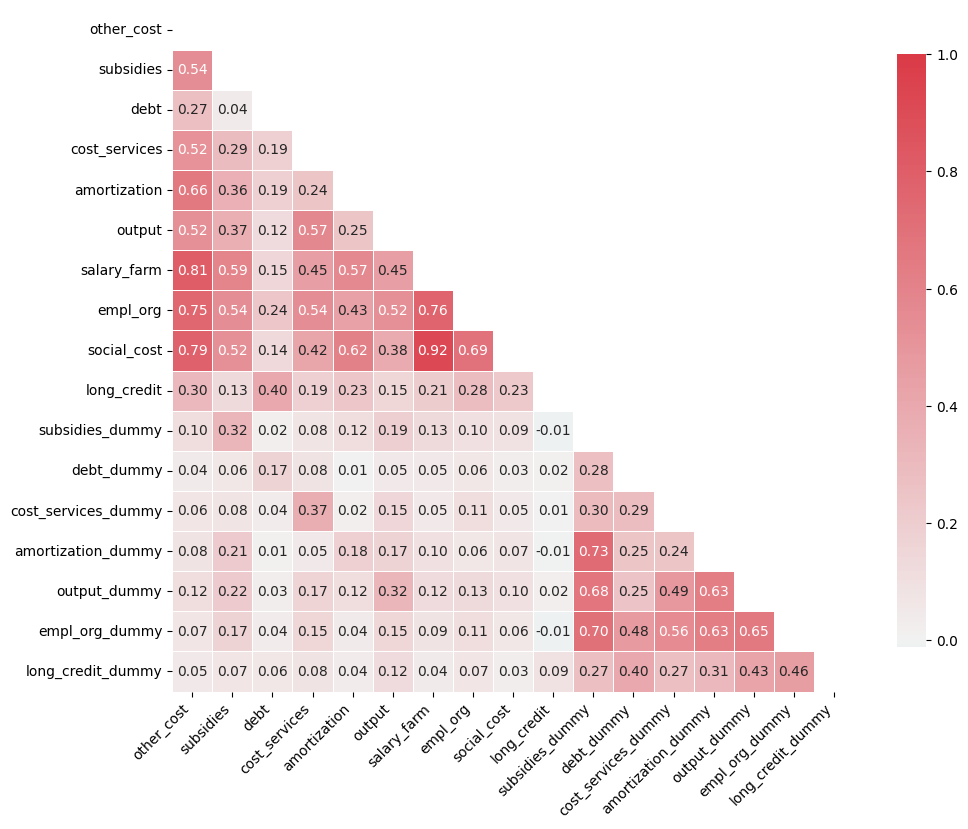

In [73]:
X_no_ghost_C = X_no_ghost.drop(['other_cost_dummy', 'salary_farm_dummy', 'social_cost_dummy'], axis=1)
corr_C = X_no_ghost_C.drop('const', axis=1).corr()
mask = np.zeros_like(corr_C, dtype=bool)
mask[np.triu_indices_from(mask)] = True
figure, ax = plt.subplots(figsize=(11, 11), dpi=100)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(corr_C, mask=mask, cmap=cmap, vmax=1, center=0, square=True,
                 linewidth=.5, cbar_kws={'shrink': .7}, annot=True, fmt='.2f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [74]:
X_no_ghost_C = X_no_ghost.drop(['other_cost_dummy', 'salary_farm_dummy', 'social_cost_dummy'], axis=1)
model_C = sm.OLS(y_no_ghost, X_no_ghost_C)
results_C = model_C.fit()
print(results_C.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     152.5
Date:                Sat, 23 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:43:15   Log-Likelihood:                -28347.
No. Observations:                2516   AIC:                         5.673e+04
Df Residuals:                    2498   BIC:                         5.684e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5974.9579    

In [75]:
model_B_stats = {
    'Model': 'Model B (Original)',
    'R-squared': results_B.rsquared,
    'Adjusted R-squared': results_B.rsquared_adj,
    'AIC': results_B.aic,
    'BIC': results_B.bic,
    'F-statistic': results_B.fvalue,
    'F-statistic p-value': results_B.f_pvalue
}

model_C_stats = {
    'Model': 'Model C (Modified)',
    'R-squared': results_C.rsquared,
    'Adjusted R-squared': results_C.rsquared_adj,
    'AIC': results_C.aic,
    'BIC': results_C.bic,
    'F-statistic': results_C.fvalue,
    'F-statistic p-value': results_C.f_pvalue
}

model_comparison = pd.DataFrame([model_B_stats, model_C_stats])
model_comparison

,Model,R-squared,Adjusted R-squared,AIC,BIC,F-statistic,F-statistic p-value
0,Model B (Original),0.510448,0.506524,56730.874908,56853.313846,130.074723,0.0
1,Model C (Modified),0.509351,0.506012,56730.507391,56835.455052,152.541896,0.0


After alternately deleting variables, it was decided to delete only variables related to social costs. We need to conduct another test for heteroscedasticity in order to make corrections and finally understand which coefficients are insignificant.

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
_, p_value, _, _ = het_breuschpagan(results_C.resid, X_no_ghost_C)

if p_value < 0.005:
  print(f'Rejected null hypothesis and concluded that there is hetoroscedastisity: {p_value:.3f}')
else:
  print(f'Accept null hypothesis and concluded that there is no hetoroscedastisity: {p_value:.3f}')

Rejected null hypothesis and concluded that there is hetoroscedastisity: 0.000


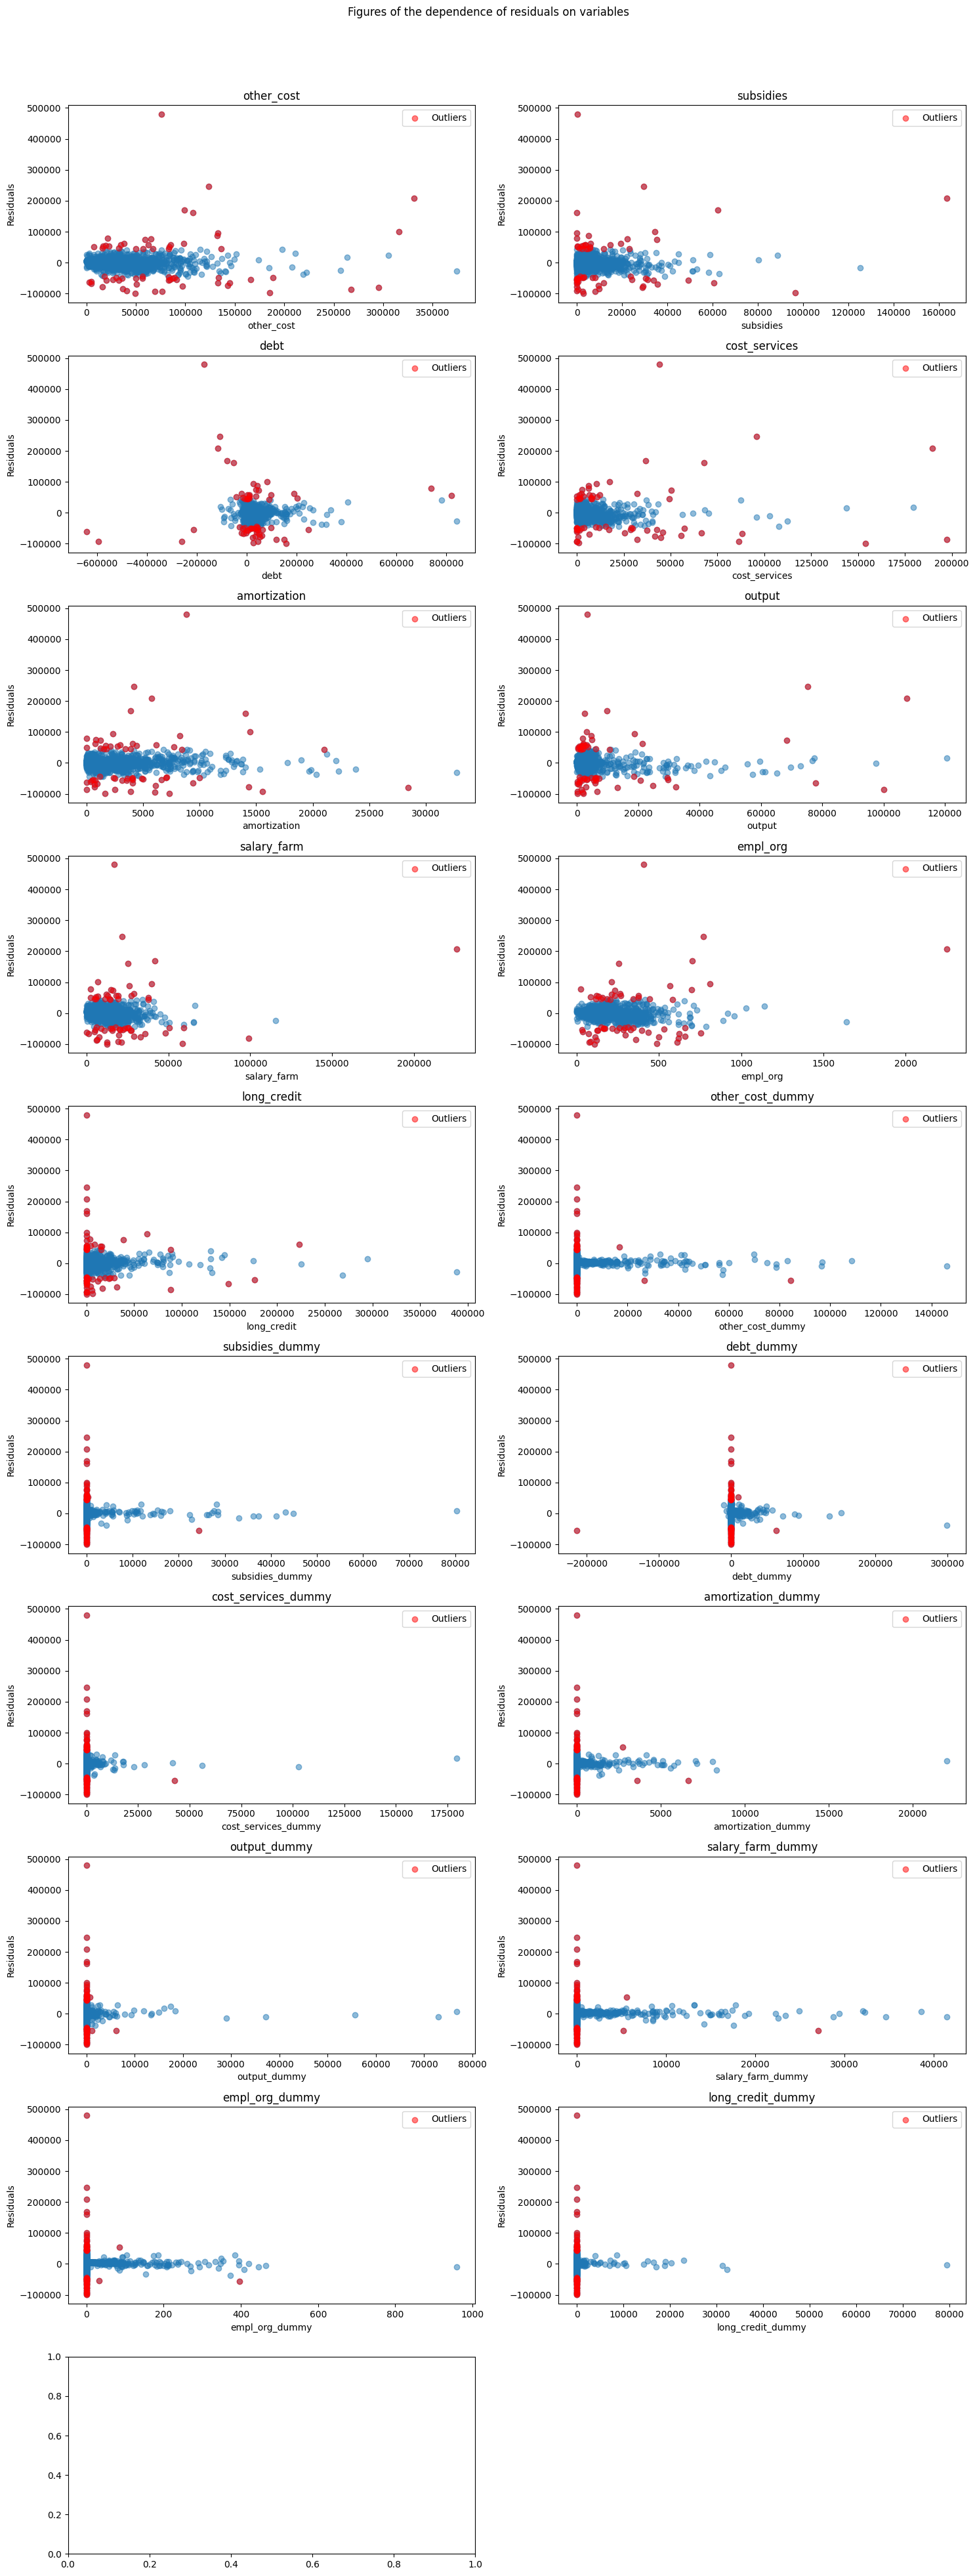

In [ ]:
residuals = results_C.resid
residual_threshold = np.percentile(residuals**2, 97.5)
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, num_rows*4))
fig.suptitle('Figures of the dependence of residuals on variables')
for i, col in enumerate(X_no_ghost_C.drop('const', axis=1).columns):
    ax = axes[i // 2, i % 2]
    ax.scatter(X_no_ghost_C[col], residuals, alpha=0.5)
    outliers = np.where(residuals**2 > residual_threshold)[0]
    ax.scatter(X_no_ghost_C[col].iloc[outliers], residuals.iloc[outliers], color='red', alpha=0.5, label='Outliers')
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Residuals')
    ax.legend()
if num_cols % 2 != 0:
    fig.delaxes(axes[-1, -1])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Both tests showed the presence of heteroscedasticity. We can use errors that are resistant to heteroscedasticity.

In [ ]:
results_C_HC3 = model_C.fit(cov_type='HC3')

In [ ]:
print(results_C_HC3.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     7.543
Date:                Sat, 18 Nov 2023   Prob (F-statistic):           1.66e-19
Time:                        12:53:29   Log-Likelihood:                -28345.
No. Observations:                2516   AIC:                         5.673e+04
Df Residuals:                    2497   BIC:                         5.684e+04
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5973.4314   1

In [ ]:
_, p_value, _, _ = het_breuschpagan(results_C_HC3.resid, X_no_ghost_C)

if p_value < 0.005:
  print(f'Rejected null hypothesis and concluded that there is hetoroscedastisity: {p_value:.3f}')
else:
  print(f'Accept null hypothesis and concluded that there is no hetoroscedastisity: {p_value:.3f}')

Rejected null hypothesis and concluded that there is hetoroscedastisity: 0.000


Unfortunately, it was not possible to get rid of heteroskedasticity. you can try other methods.



In [ ]:
# WLS
X_no_ghost_C = X_no_ghost.drop(['social_cost', 'social_cost_dummy'], axis=1)
model_C = sm.OLS(y_no_ghost, X_no_ghost_C)
results_C = model_C.fit()
weights = 1.0 / np.sqrt(np.abs(results_C.resid))
model_WLS = sm.WLS(y_no_ghost, X_no_ghost_C, weights=weights)
results_WLS = model_WLS.fit()

print(results_WLS.summary())

                            WLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.606
Model:                            WLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     213.8
Date:                Sat, 18 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:10:14   Log-Likelihood:                -26600.
No. Observations:                2516   AIC:                         5.324e+04
Df Residuals:                    2497   BIC:                         5.335e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4496.6091    

In [ ]:
_, p_value, _, _ = het_breuschpagan(results_WLS.resid, X_no_ghost_C)

if p_value < 0.005:
  print(f'Rejected null hypothesis and concluded that there is hetoroscedastisity: {p_value:.3f}')
else:
  print(f'Accept null hypothesis and concluded that there is no hetoroscedastisity: {p_value:.3f}')

Rejected null hypothesis and concluded that there is hetoroscedastisity: 0.000


In [ ]:
# GLS
model_GLS = sm.GLS(y_no_ghost, X_no_ghost_C)
results_GLS = model_GLS.fit()
print(results_GLS.summary())

                            GLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.510
Model:                            GLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     144.6
Date:                Sat, 18 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:15:24   Log-Likelihood:                -28345.
No. Observations:                2516   AIC:                         5.673e+04
Df Residuals:                    2497   BIC:                         5.684e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5973.4314    

In [ ]:
# RLM
model_RLM = sm.RLM(y_no_ghost, X_no_ghost_C)
results_RLM = model_RLM.fit()
print(results_RLM.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             net_profit   No. Observations:                 2516
Model:                            RLM   Df Residuals:                     2497
Method:                          IRLS   Df Model:                           18
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 18 Nov 2023                                         
Time:                        13:18:03                                         
No. Iterations:                    17                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2382.5347    

Among all these methods, the weighted least squares (WLS) method was found to be the most effective in dealing with heteroscedasticity. However, it was observed that none of the methods including WLS completely eliminated the problem of heteroscedasticity. The reasons for the failure of the methods to completely eliminate heteroscedasticity may be multifaceted:

Incorrect model specification: If the underlying model is not specified correctly, no method, including robust methods such as WLS, can completely eliminate the problem.

In [ ]:
X_no_ghost_C = X_no_ghost.drop(['social_cost', 'social_cost_dummy',
                                'salary_farm_dummy', 'output_dummy'], axis=1)
model_C = sm.OLS(y_no_ghost, X_no_ghost_C)
results_C = model_C.fit()
weights = 1.0 / np.sqrt(np.abs(results_C.resid))
model_WLS = sm.WLS(y_no_ghost, X_no_ghost_C, weights=weights)
results_WLS = model_WLS.fit()

print(results_WLS.summary())

                            WLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.628
Model:                            WLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     264.2
Date:                Sat, 18 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:31:25   Log-Likelihood:                -26605.
No. Observations:                2516   AIC:                         5.324e+04
Df Residuals:                    2499   BIC:                         5.334e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4456.6298    

## **Note**
After some analysis, the need to split the sample into two separate strata became clear. Although it is clear from the description of the data that even this breakdown is not sufficient to build a qualitative model. It is necessary to split each stratum, i.e. agricultural organizations and peasant (farm) households into several strata. Perhaps, after the whole analysis, we will conduct a similar trick as an addition and see what happens. This model is untenable for a clear representation of the economic state of the industry as a whole within the framework of the data breakdown provided to us.

In [ ]:
column_names = ['net_profit', 'other_cost', 'subsidies', 'debt',
                'cost_services', 'amortization', 'output', 'salary_farm',
                'empl_org', 'KOPF', 'social_cost', 'long_credit']
livestock = df[column_names]
livestock['dumm'] = 0
livestock.loc[livestock['KOPF'] == 42, 'dumm'] = 1
livestock = livestock.drop('KOPF', axis=1)
livestock = livestock.rename(columns={'dumm' : 'KOPF'})
livestock = livestock.drop([418, 1395])
livestock = livestock.reset_index(drop=True)
livestock_no_ghost = livestock.loc[~((livestock['output'] == 0) & (livestock['salary_farm'] == 0))]
df_org = livestock_no_ghost[(livestock_no_ghost['KOPF'] == 0)]
df_farm = livestock_no_ghost[(livestock_no_ghost['KOPF'] == 1)]
df_org = df_org.drop('KOPF', axis=1)
df_farm = df_farm.drop('KOPF', axis=1)
df_org.shape, df_farm.shape

((2247, 11), (269, 11))

In [ ]:
X_org = df_org.drop('net_profit', axis=1)
X_org = sm.add_constant(X_org)
y_org = df_org['net_profit']
model_org = sm.OLS(y_org, X_org)
results_org = model_org.fit()

In [ ]:
X_farm = df_farm.drop('net_profit', axis=1)
X_farm = sm.add_constant(X_farm)
y_farm = df_farm['net_profit']
model_farm = sm.OLS(y_farm, X_farm)
results_farm = model_farm.fit()


In [ ]:
weights = 1.0 / np.sqrt(np.abs(results_org.resid))
model_org_WLS = sm.WLS(y_org, X_org, weights=weights)
results_org_WLS = model_org_WLS.fit()

print(results_org_WLS.summary())

                            WLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.623
Model:                            WLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     369.5
Date:                Mon, 20 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:18:53   Log-Likelihood:                -23847.
No. Observations:                2247   AIC:                         4.772e+04
Df Residuals:                    2236   BIC:                         4.778e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5315.6261    339.960    -15.636

In [ ]:
weights = 1.0 / np.sqrt(np.abs(results_farm.resid))
model_farm_WLS = sm.WLS(y_farm, X_farm, weights=weights)
results_farm_WLS = model_farm_WLS.fit()

print(results_farm_WLS.summary())

                            WLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.646
Model:                            WLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     47.15
Date:                Sat, 18 Nov 2023   Prob (F-statistic):           1.31e-52
Time:                        15:48:53   Log-Likelihood:                -2637.0
No. Observations:                 269   AIC:                             5296.
Df Residuals:                     258   BIC:                             5336.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -482.2709    285.626     -1.688

## **Endogenity**
Since the Ramsey test showed the absence of important variables in the model, we can state with great certainty that there is endogeneity in our model. After the analysis, it was found that one of the endogenous variables is the average annual number of employees of an agricultural organization (empl_org). This variable can have a rather strong correlation with revenue (BR), total planted area (ES) and also with labor costs in crop production (salary_plant).

In [ ]:
column_names = ['net_profit', 'other_cost', 'subsidies', 'debt',
                'cost_services', 'amortization', 'output', 'salary_farm',
                'empl_org', 'KOPF', 'social_cost', 'long_credit', 'ES', 'BR',
                'salary_plant']
livestock = df[column_names]
livestock['dumm'] = 0
livestock.loc[livestock['KOPF'] == 42, 'dumm'] = 1
livestock = livestock.drop('KOPF', axis=1)
livestock = livestock.rename(columns={'dumm' : 'KOPF'})
livestock = livestock.drop([418, 1395])
livestock = livestock.reset_index(drop=True)
livestock_no_ghost = livestock.loc[~((livestock['output'] == 0) \
                                     & (livestock['salary_farm'] == 0))]
df_org = livestock_no_ghost[(livestock_no_ghost['KOPF'] == 0)]
df_farm = livestock_no_ghost[(livestock_no_ghost['KOPF'] == 1)]
df_org = df_org.drop('KOPF', axis=1)
df_farm = df_farm.drop('KOPF', axis=1)
df_org.shape, df_farm.shape

((2247, 14), (269, 14))

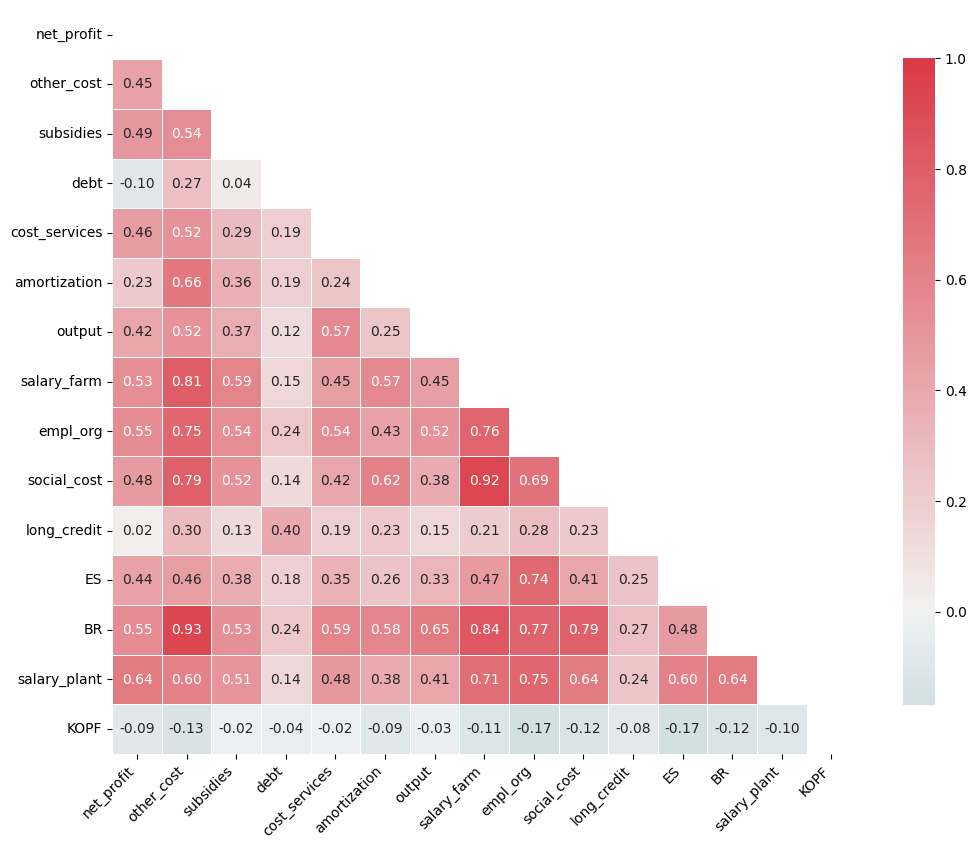

In [ ]:
corr = livestock_no_ghost.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
figure, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True,
                 linewidth=.5, cbar_kws={'shrink': .7}, annot=True, fmt='.2f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Correlation matrix shows us that the **ES, BR and salary_plant** variables do correlate with **empl_org**, but there is also a little correlation with the dependent variable **net_profit**. We should try to conduct endogenity tests.

In [ ]:
df_org = livestock_no_ghost[(livestock_no_ghost['KOPF'] == 0)]
df_farm = livestock_no_ghost[(livestock_no_ghost['KOPF'] == 1)]
df_org = df_org.drop('KOPF', axis=1)
df_farm = df_farm.drop('KOPF', axis=1)

In [ ]:
X_org = df_org.drop(['net_profit', 'ES', 'BR',
                'salary_plant'], axis=1)
X_org = sm.add_constant(X_org)
y_org = df_org['net_profit']
model_org = sm.OLS(y_org, X_org)
results_org = model_org.fit()
weights = 1.0 / np.sqrt(np.abs(results_org.resid))
model_org_WLS = sm.WLS(y_org, X_org, weights=weights)
results_org_WLS = model_org_WLS.fit()

In [ ]:
X_farm = df_farm.drop(['net_profit', 'ES', 'BR',
                'salary_plant'], axis=1)
X_farm = sm.add_constant(X_farm)
y_farm = df_farm['net_profit']
model_farm = sm.OLS(y_farm, X_farm)
results_farm = model_farm.fit()
weights = 1.0 / np.sqrt(np.abs(results_farm.resid))
model_farm_WLS = sm.WLS(y_farm, X_farm, weights=weights)
results_farm_WLS = model_farm_WLS.fit()


                            WLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.646
Model:                            WLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     47.15
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           1.31e-52
Time:                        13:18:08   Log-Likelihood:                -2637.0
No. Observations:                 269   AIC:                             5296.
Df Residuals:                     258   BIC:                             5336.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -482.2709    285.626     -1.688

In [ ]:
import linearmodels.iv.model as lm

In [ ]:
X_org = df_org.drop(['net_profit', 'ES', 'BR', 'salary_plant'], axis=1)
X_org = sm.add_constant(X_org)
y_org = df_org['net_profit']
model_org = sm.OLS(y_org, X_org)
results_org = model_org.fit()
weights = 1.0 / np.sqrt(np.abs(results_org.resid))
model_org_WLS = sm.WLS(y_org, X_org, weights=weights)
results_org_WLS = model_org_WLS.fit()

In [ ]:
iv_model_org = lm.IV2SLS(y_org, X_org.drop('empl_org', axis=1),
                         X_org['empl_org'],
                         df_org[['ES', 'BR', 'salary_plant']], weights=weights).fit()

In [ ]:
print(iv_model_org.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:             net_profit   R-squared:                      0.6057
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6040
No. Observations:                2247   F-statistic:                    738.61
Date:                Mon, Nov 20 2023   P-value (F-stat)                0.0000
Time:                        12:19:36   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
const            -7479.6     693.50    -10.785     0.0000     -8838.8     -6120.3
other_cost       -0.1066     0.0451    -

In [ ]:
# Wu_hausman test
print(iv_model_org.wu_hausman())
print(iv_model_org.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 247.9183
P-value: 0.0000
Distributed: F(1,2235)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 11.9197
P-value: 0.0006
Distributed: chi2(1)


In [ ]:
# Sargan test
print(iv_model_org.sargan)

Sargan's test of overidentification
H0: The model is not overidentified.
Statistic: 332.9304
P-value: 0.0000
Distributed: chi2(2)


In [ ]:
X_farm = df_farm.drop(['net_profit', 'ES', 'BR', 'salary_plant'], axis=1)
X_farm = sm.add_constant(X_farm)
y_farm = df_farm['net_profit']
model_farm = sm.OLS(y_farm, X_farm)
results_farm = model_farm.fit()
weights = 1.0 / np.sqrt(np.abs(results_farm.resid))
model_farm_WLS = sm.WLS(y_farm, X_farm, weights=weights)
results_farm_WLS = model_farm_WLS.fit()

In [ ]:
iv_model_farm = lm.IV2SLS(y_farm, X_farm.drop('empl_org', axis=1),
                         X_farm['empl_org'],
                         df_farm[['ES', 'BR', 'salary_plant']], weights=weights).fit()

In [ ]:
print(iv_model_farm.wu_hausman())
print(iv_model_farm.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 13.7888
P-value: 0.0003
Distributed: F(1,257)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 2.6115
P-value: 0.1061
Distributed: chi2(1)


In [ ]:
print(iv_model_farm.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:             net_profit   R-squared:                      0.6336
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6194
No. Observations:                 269   F-statistic:                    632.18
Date:                Mon, Nov 20 2023   P-value (F-stat)                0.0000
Time:                        12:19:57   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
const            -865.90     234.88    -3.6865     0.0002     -1326.3     -405.54
other_cost       -0.2929     0.0698    -

All tests show that 2OLS models appropriate for our analysis

## **Apply GMM model (Generalized Method of Moments)**

In [ ]:
iv_GMM_org = lm.IVGMM(y_org, X_org.drop('empl_org', axis=1),
                         X_org['empl_org'],
                         df_org[['ES', 'BR', 'salary_plant']], weights=weights,
                      weight_type='robust').fit()

In [ ]:
iv_GMM_farm = lm.IVGMM(y_farm, X_farm.drop('empl_org', axis=1),
                         X_farm['empl_org'],
                         df_farm[['ES', 'BR', 'salary_plant']], weights=weights,
                       weight_type='robust').fit()

In [ ]:
iv_GMM_org

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:             net_profit   R-squared:                      0.5501
Estimator:                     IV-GMM   Adj. R-squared:                 0.5481
No. Observations:                2247   F-statistic:                    753.21
Date:                Sun, Nov 19 2023   P-value (F-stat)                0.0000
Time:                        12:53:45   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
const            -4656.4     563.14    -8.2686     0.0000     -5760.1     -3552.7
other_cost        0.0466     0.0446     1.0443     0.2963     -0.0408      0.1339
subsidies         0.3854     0.1076     3.5830     0.0003      0.1746      0.5963
debt             -0.0937     0.0161    -5.8165     0.0000     -0.1252     -0.0621
cost_services     0.3346     0.1126     2.9729     0.0030      0.1140      0.5552
amortization      0.2279     0.1946     1.1712     0.2415     -0.1535      0.6093
output            0.1274     0.1122     1.1348     0.2565     -0.0926      0.3473
salary_farm      -0.5895     0.2444    -2.4117     0.0159     -1.0686     -0.1104
social_cost       2.5225     0.9898     2.5485     0.0108      0.5825      4.4625
long_credit      -0.0663     0.0283    -2.3435     0.0191     -0.1217     -0.0108
empl_org          67.774     6.7101     10.100     0.0000      54.622      80.925
=================================================================================

Endogenous: empl_org
Instruments: ES, BR, salary_plant
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
IVGMMResults, id: 0x7b37361c5ae0

In [ ]:
iv_GMM_farm

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:             net_profit   R-squared:                      0.6353
Estimator:                     IV-GMM   Adj. R-squared:                 0.6212
No. Observations:                 269   F-statistic:                    518.20
Date:                Sun, Nov 19 2023   P-value (F-stat)                0.0000
Time:                        12:55:33   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
const            -740.70     178.67    -4.1457     0.0000     -1090.9     -390.52
other_cost       -0.2727     0.0655    -4.1625     0.0000     -0.4011     -0.1443
subsidies         0.1146     0.0873     1.3126     0.1893     -0.0565      0.2858
debt             -0.2703     0.0392    -6.8989     0.0000     -0.3471     -0.1935
cost_services    -0.0508     0.0553    -0.9185     0.3583     -0.1593      0.0576
amortization      1.6632     0.4381     3.7960     0.0001      0.8045      2.5219
output            0.1404     0.0927     1.5145     0.1299     -0.0413      0.3222
salary_farm       0.0660     0.1565     0.4219     0.6731     -0.2408      0.3729
social_cost      -0.8922     1.3928    -0.6406     0.5218     -3.6220      1.8376
long_credit       0.4225     0.0917     4.6065     0.0000      0.2427      0.6023
empl_org          61.668     8.2450     7.4794     0.0000      45.508      77.828
=================================================================================

Endogenous: empl_org
Instruments: ES, BR, salary_plant
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
IVGMMResults, id: 0x7b3736faee60

In [ ]:
from linearmodels.iv.results import compare

res = {'2SLS_Org': iv_model_org,
       '2SLS_Farm': iv_model_farm,
       'GMM_Org': iv_GMM_org,
       'GMM_Farm': iv_GMM_farm}
print(compare(res))

                                Model Comparison                                
                           2SLS_Org      2SLS_Farm        GMM_Org       GMM_Farm
--------------------------------------------------------------------------------
Dep. Variable            net_profit     net_profit     net_profit     net_profit
Estimator                   IV-2SLS        IV-2SLS         IV-GMM         IV-GMM
No. Observations               2247            269           2247            269
Cov. Est.                    robust         robust         robust         robust
R-squared                    0.6057         0.6336         0.5501         0.6353
Adj. R-squared               0.6040         0.6194         0.5481         0.6212
F-statistic                  738.61         632.18         753.21         518.20
P-value (F-stat)             0.0000         0.0000         0.0000         0.0000
==================     ============   ============   ============   ============
const                       

In [ ]:
pvalues_df = pd.DataFrame({
    '2SLS_Org': iv_model_org.pvalues.round(4),
    'GMM_Org': iv_GMM_org.pvalues.round(4),
    '2SLS_Farm' : iv_model_farm.pvalues.round(4),
    'GMM_Farm' : iv_GMM_farm.pvalues.round(4)
})
print(pvalues_df)

               2SLS_Org  GMM_Org  2SLS_Farm  GMM_Farm
const            0.0000   0.0000     0.0002    0.0000
other_cost       0.0182   0.2963     0.0000    0.0000
subsidies        0.0000   0.0003     0.1007    0.1893
debt             0.0000   0.0000     0.0000    0.0000
cost_services    0.0000   0.0030     0.2772    0.3583
amortization     0.3486   0.2415     0.0009    0.0001
output           0.0066   0.2565     0.0873    0.1299
salary_farm      0.2458   0.0159     0.5913    0.6731
social_cost      0.4034   0.0108     0.3899    0.5218
long_credit      0.0001   0.0191     0.0010    0.0000
empl_org         0.0000   0.0000     0.0000    0.0000


## **Conclusion**
The choice of a more preferable model is quite difficult. In fact, both models show similar results, but still, the goal of our analysis was to obtain reasonable and efficient estimates. Provided that we found strong heteroskedasticity in our data, the IVGMM model is preferred because it accounts for heteroskedasticity of an unknown kind, and moreover, in the presence of heteroskedasticity, its estimates are more efficient than the IV2SLS model. In addition, the model reduces the influence of non-typical observations due to the difference in weights (for strong deviations the weights will be smaller).

Thus, the following results are obtained for agricultural organizations taking into account the IVGMM model:

1. The insignificance of the variable other_cost for large companies indicates the strong influence of economies of scale, with an increase in this variable even increasing profits by 0.05 times.
2. A high dependence on subsidies and government support can be seen (an increase of 0.40 times), indicating the importance of continuous financing of enterprises to increase economic performance in this sector. Although there is a reverse side of this issue: increasing dependence of enterprises on additional financial injections.
3. The difference between short-term accounts payable and accounts receivable is also very significant. If this indicator increases, the profit decreases by 0.09 times.
4. Increase in the costs of work, services and sold products increase profits, and significantly (0.33 times). This suggests that companies should also focus not only on their core activities, but also engage in outsourcing and other activities.
5. Depreciation is not significant for large companies, although it has a positive impact on profit.
6. The output in this case was still insignificant. This can be attributed to the fact that for agricultural producers the price of production is important in the first place, not the quantity. This is a characteristic feature of the industry as a whole. Price volatility is one of the main problems.
7. Labor costs play a significant role and reduce profit by 0.5 times.
8. Social costs in the final model still turned out to be significant, and they increase profit by 2.5 times. Most likely, this may be due to additional state support of enterprises that are actively involved in solving social problems.
9. Long-term loans insignificantly reduce the company's profit and are significant. Perhaps it is all about the size of the loan for large companies. A large loan is harder to service.
10. The number of employees most strongly affects the profit. This indicator increases it 67 times. For 2016 this is quite normal. It is thought that for 2021 this value will drop, as the automation factor will influence more.

The peculiarities of peasant (farmer) farms (their difference from agricultural organizations) are associated primarily with the impact on profit of a certain type of costs. The importance of other costs and the importance of depreciation increases, and this is quite obvious, since for smaller farms there is no possibility to fully use the scale effect. The impact of the difference between accounts payable and accounts receivable increases: with an increase by 1, the profit decreases by 0.27 times. The indicator of depreciation increases profit by 1.6 times. At the same time, the indicators of wages and social costs have no impact on profit, and this may be due to a lower labor remuneration fund, as well as less participation of peasant (farm) farms in social projects. Interestingly, long-term loans on the contrary increase profit for these types of farms by 0.42 times. This may be due to the greater flexibility of enterprises in servicing loans and the size of the loans themselves. The indicator of subsidies is insignificant for this type of farms, which is quite obvious, since the costs of subsidies for smaller enterprises may be higher than the subsidies themselves. Simply put, it is not profitable for peasant (farm) households to receive subsidies under these conditions.

To summarize, we can highlight several points. The state should pay more attention to the format of subsidies for small enterprises and make them more accessible. But for large enterprises it is necessary to consider the issues of improving preferential lending, so that the impact of long-term loans was positive, not negative. It is also necessary to stimulate the participation of peasant (farmer) farms in various social programs.